## 1. Import Libraries

In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For fetching economic data
try:
    import pandas_datareader as pdr
    from pandas_datareader import data as web
    print("pandas_datareader imported successfully")
except ImportError:
    print("pandas_datareader not found. Installing...")
    import sys
    !{sys.executable} -m pip install pandas-datareader
    import pandas_datareader as pdr
    from pandas_datareader import data as web
    print("pandas_datareader installed and imported")

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

pandas_datareader imported successfully
Libraries imported successfully!


## 2. Load Stock Data

In [13]:
# Load existing stock data and performance metrics
sector_df = pd.read_csv('sector_stocks.csv')
performance_df = pd.read_csv('stock_performance_summary.csv')

# Load price data
price_data = pd.read_pickle('price_data_all_stocks_cache.pkl')

print(f"Stocks loaded: {len(sector_df)}")
print(f"Performance data: {len(performance_df)}")
print(f"Price data shape: {price_data.shape}")
print(f"Date range: {price_data.index[0]} to {price_data.index[-1]}")

Stocks loaded: 302
Performance data: 302
Price data shape: (500, 1505)
Date range: 2024-01-12 00:00:00 to 2026-01-09 00:00:00


In [14]:
# Extract Close prices and calculate aggregate sector indices
if isinstance(price_data.columns, pd.MultiIndex):
    adj_close = price_data.xs('Close', level=0, axis=1)
else:
    adj_close = price_data

# Remove all-NaN columns
adj_close = adj_close.dropna(axis=1, how='all')

print(f"Clean price data shape: {adj_close.shape}")
print(f"Valid stocks: {len(adj_close.columns)}")

# Calculate sector-level price indices
sector_indices = {}
for sector in sector_df['Sector_Code'].unique():
    sector_stocks = sector_df[sector_df['Sector_Code'] == sector]['Symbol'].tolist()
    # Get stocks that exist in our price data
    available_stocks = [s for s in sector_stocks if s in adj_close.columns]
    if available_stocks:
        sector_indices[sector] = adj_close[available_stocks].mean(axis=1)

sector_index_df = pd.DataFrame(sector_indices)
print(f"\nSector indices created for: {list(sector_indices.keys())}")
sector_index_df.head()

Clean price data shape: (500, 301)
Valid stocks: 301

Sector indices created for: ['XLK', 'XLV', 'XLF', 'XLI', 'XLY']


,XLK,XLV,XLF,XLI,XLY
Date,,,,,
2024-01-12,211.442023,233.175475,151.709361,198.395458,404.556369
2024-01-16,211.570764,232.045906,151.082555,197.016024,405.648156
2024-01-17,210.124634,230.519296,150.649545,195.797213,403.360316
2024-01-18,213.795464,231.434707,151.302292,198.565310,408.281505
2024-01-19,218.255586,231.547608,153.447677,199.633213,411.969212


## 3. Fetch Economic Data

We'll use FRED (Federal Reserve Economic Data) via pandas_datareader to fetch key economic indicators.

In [15]:
# Define date range matching our stock data
start_date = price_data.index[0]
end_date = price_data.index[-1]

print(f"Fetching economic data from {start_date} to {end_date}")

# FRED data series codes - Comprehensive Economic Indicators
fred_series = {
    # Monetary Policy & Interest Rates
    'M2': 'M2SL',                    # M2 Money Supply
    'FED_FUNDS': 'FEDFUNDS',         # Federal Funds Rate
    'TREASURY_10Y': 'DGS10',         # 10-Year Treasury Yield
    'TREASURY_2Y': 'DGS2',           # 2-Year Treasury Yield
    'TREASURY_5Y': 'DGS5',           # 5-Year Treasury Yield
    
    # Economic Growth & Output
    'GDP': 'GDP',                    # GDP (Quarterly)
    'INDUSTRIAL_PROD': 'INDPRO',     # Industrial Production Index
    'CAPACITY_UTIL': 'TCU',          # Capacity Utilization
    
    # Inflation & Prices
    'CPI': 'CPIAUCSL',               # Consumer Price Index
    'PPI': 'PPIACO',                 # Producer Price Index
    'PCE': 'PCE',                    # Personal Consumption Expenditures
    'CORE_CPI': 'CPILFESL',          # Core CPI (ex food & energy)
    
    # Labor Market
    'UNEMPLOYMENT': 'UNRATE',        # Unemployment Rate
    'NONFARM_PAYROLL': 'PAYEMS',     # Non-farm Payrolls
    'LABOR_FORCE_PART': 'CIVPART',   # Labor Force Participation Rate
    'INITIAL_CLAIMS': 'ICSA',        # Initial Jobless Claims
    
    # Consumer & Sentiment
    'RETAIL_SALES': 'RSAFS',         # Retail Sales
    'CONSUMER_SENTIMENT': 'UMCSENT', # University of Michigan Consumer Sentiment
    'PERSONAL_INCOME': 'PI',         # Personal Income
    
    # Housing Market
    'HOUSING_STARTS': 'HOUST',       # Housing Starts
    'NEW_HOME_SALES': 'HSN1F',       # New Home Sales
    'EXISTING_HOME_SALES': 'EXHOSLUSM495S', # Existing Home Sales
    
    # Credit & Money Markets
    'CORP_BOND_SPREAD': 'BAA10Y',    # BAA Corporate Bond Yield Spread
    'CREDIT_SPREAD': 'BAMLH0A0HYM2', # High Yield Credit Spread
}

print("\nEconomic indicators to fetch:")
for name, code in fred_series.items():
    print(f"  - {name}: {code}")

Fetching economic data from 2024-01-12 00:00:00 to 2026-01-09 00:00:00

Economic indicators to fetch:
  - M2: M2SL
  - FED_FUNDS: FEDFUNDS
  - TREASURY_10Y: DGS10
  - TREASURY_2Y: DGS2
  - TREASURY_5Y: DGS5
  - GDP: GDP
  - INDUSTRIAL_PROD: INDPRO
  - CAPACITY_UTIL: TCU
  - CPI: CPIAUCSL
  - PPI: PPIACO
  - PCE: PCE
  - CORE_CPI: CPILFESL
  - UNEMPLOYMENT: UNRATE
  - NONFARM_PAYROLL: PAYEMS
  - LABOR_FORCE_PART: CIVPART
  - INITIAL_CLAIMS: ICSA
  - RETAIL_SALES: RSAFS
  - CONSUMER_SENTIMENT: UMCSENT
  - PERSONAL_INCOME: PI
  - HOUSING_STARTS: HOUST
  - NEW_HOME_SALES: HSN1F
  - EXISTING_HOME_SALES: EXHOSLUSM495S
  - CORP_BOND_SPREAD: BAA10Y
  - CREDIT_SPREAD: BAMLH0A0HYM2


In [ ]:
# Fetch economic data from FRED
import os
from datetime import datetime, timedelta

economic_cache = 'economic_data_cache.pkl'

# Define cache validity period (e.g., 1 week = 7 days)
CACHE_VALIDITY_DAYS = 7

cache_is_valid = False

if os.path.exists(economic_cache):
    print(f"Found cached economic data file '{economic_cache}'. Checking freshness...")
    economic_data = pd.read_pickle(economic_cache)
    
    # Check the last date in the cache
    cache_end_date = economic_data.index[-1]
    current_date = datetime.now()
    days_old = (current_date - cache_end_date).days
    
    print(f"Cached data ends on: {cache_end_date.strftime('%Y-%m-%d')}")
    print(f"Cache is {days_old} days old")
    
    if days_old <= CACHE_VALIDITY_DAYS:
        cache_is_valid = True
        print(f" Cache is fresh (less than {CACHE_VALIDITY_DAYS} days old). Using cached data.")
        print(f"Loaded economic data shape: {economic_data.shape}")
        print(f"Cached data includes: {economic_data.columns.tolist()}")
    else:
        print(f"Cache is stale (more than {CACHE_VALIDITY_DAYS} days old). Will re-download data.")

if not cache_is_valid:
    print(f"\nFetching economic data from FRED...\n")
    economic_data = pd.DataFrame()
    
    for name, series_code in fred_series.items():
        try:
            print(f"Fetching {name} ({series_code})...")
            data = web.DataReader(series_code, 'fred', start_date, end_date)
            economic_data[name] = data.iloc[:, 0]
            print(f"  {name}: {len(data)} data points")
        except Exception as e:
            print(f" Error fetching {name}: {str(e)}")
    
    # Fetch VIX from Yahoo Finance
    print("\nFetching VIX (Volatility Index) from Yahoo Finance...")
    try:
        vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)['Close']
        vix.name = 'VIX'
        economic_data = economic_data.join(vix, how='outer')
        print(f"  VIX: {len(vix)} data points")
    except Exception as e:
        print(f"  Error fetching VIX: {str(e)}")
    
    # Fetch Oil Prices (WTI Crude)
    print("\nFetching Oil Prices (WTI Crude) from Yahoo Finance...")
    try:
        oil = yf.download('CL=F', start=start_date, end=end_date, progress=False)['Close']
        oil.name = 'OIL_WTI'
        economic_data = economic_data.join(oil, how='outer')
        print(f"  OIL_WTI: {len(oil)} data points")
    except Exception as e:
        print(f"  Error fetching OIL_WTI: {str(e)}")
    
    # Fetch US Dollar Index
    print("\nFetching US Dollar Index (DXY) from Yahoo Finance...")
    try:
        dxy = yf.download('DX-Y.NYB', start=start_date, end=end_date, progress=False)['Close']
        dxy.name = 'USD_INDEX'
        economic_data = economic_data.join(dxy, how='outer')
        print(f"  USD_INDEX: {len(dxy)} data points")
    except Exception as e:
        print(f"  Error fetching USD_INDEX: {str(e)}")
    
    # Fetch Gold Prices
    print("\nFetching Gold Prices from Yahoo Finance...")
    try:
        gold = yf.download('GC=F', start=start_date, end=end_date, progress=False)['Close']
        gold.name = 'GOLD'
        economic_data = economic_data.join(gold, how='outer')
        print(f"  GOLD: {len(gold)} data points")
    except Exception as e:
        print(f"  Error fetching GOLD: {str(e)}")
    
    # Save cache with all commodities and indices
    economic_data.to_pickle(economic_cache)
    print(f"\nEconomic data (with VIX, Oil, USD Index, Gold) cached to '{economic_cache}'")

print(f"\nEconomic data shape: {economic_data.shape}")
print(f"Date range: {economic_data.index[0]} to {economic_data.index[-1]}")
economic_data.head(10)

Found cached economic data file 'economic_data_cache.pkl'. Checking freshness...
Cached data ends on: 2026-01-08
Cache is 3 days old
 Cache is fresh (less than 7 days old). Using cached data.
Loaded economic data shape: (511, 28)
Cached data includes: ['M2', 'FED_FUNDS', 'TREASURY_10Y', 'TREASURY_2Y', 'TREASURY_5Y', 'GDP', 'INDUSTRIAL_PROD', 'CAPACITY_UTIL', 'CPI', 'PPI', 'PCE', 'CORE_CPI', 'UNEMPLOYMENT', 'NONFARM_PAYROLL', 'LABOR_FORCE_PART', 'INITIAL_CLAIMS', 'RETAIL_SALES', 'CONSUMER_SENTIMENT', 'PERSONAL_INCOME', 'HOUSING_STARTS', 'NEW_HOME_SALES', 'EXISTING_HOME_SALES', 'CORP_BOND_SPREAD', 'CREDIT_SPREAD', '^VIX', 'CL=F', 'DX-Y.NYB', 'GC=F']

Economic data shape: (511, 28)
Date range: 2024-01-12 00:00:00 to 2026-01-08 00:00:00


,M2,FED_FUNDS,TREASURY_10Y,TREASURY_2Y,TREASURY_5Y,GDP,INDUSTRIAL_PROD,CAPACITY_UTIL,CPI,PPI,...,PERSONAL_INCOME,HOUSING_STARTS,NEW_HOME_SALES,EXISTING_HOME_SALES,CORP_BOND_SPREAD,CREDIT_SPREAD,^VIX,CL=F,DX-Y.NYB,GC=F
2024-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.70,72.680000,102.400002,2046.699951
2024-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.84,72.400002,103.360001,2026.000000
2024-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.79,72.559998,103.449997,2002.599976
2024-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.13,74.080002,103.540001,2018.599976
2024-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.30,73.410004,103.290001,2026.500000
2024-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.19,75.190002,103.330002,2019.800049
2024-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.55,74.370003,103.620003,2023.699951
2024-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.14,75.089996,103.239998,2013.900024
2024-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.45,77.360001,103.570000,2016.900024
2024-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.26,78.010002,103.470001,2016.800049


In [17]:
# VIX, Oil, USD Index and Gold are now included in the cached economic data above
# This cell kept for reference but data is already loaded
# Rename columns for consistency
economic_data = economic_data.rename(columns={
    '^VIX': 'VIX',
    'CL=F': 'OIL_WTI',
    'DX-Y.NYB': 'USD_INDEX',
    'GC=F': 'GOLD'
})

print("Market indicators (VIX, Oil, USD Index, Gold) already included in economic_data")
print(f"Economic data shape: {economic_data.shape}")
print(f"Columns: {economic_data.columns.tolist()}")
economic_data.tail()

Market indicators (VIX, Oil, USD Index, Gold) already included in economic_data
Economic data shape: (511, 28)
Columns: ['M2', 'FED_FUNDS', 'TREASURY_10Y', 'TREASURY_2Y', 'TREASURY_5Y', 'GDP', 'INDUSTRIAL_PROD', 'CAPACITY_UTIL', 'CPI', 'PPI', 'PCE', 'CORE_CPI', 'UNEMPLOYMENT', 'NONFARM_PAYROLL', 'LABOR_FORCE_PART', 'INITIAL_CLAIMS', 'RETAIL_SALES', 'CONSUMER_SENTIMENT', 'PERSONAL_INCOME', 'HOUSING_STARTS', 'NEW_HOME_SALES', 'EXISTING_HOME_SALES', 'CORP_BOND_SPREAD', 'CREDIT_SPREAD', 'VIX', 'OIL_WTI', 'USD_INDEX', 'GOLD']


,M2,FED_FUNDS,TREASURY_10Y,TREASURY_2Y,TREASURY_5Y,GDP,INDUSTRIAL_PROD,CAPACITY_UTIL,CPI,PPI,...,PERSONAL_INCOME,HOUSING_STARTS,NEW_HOME_SALES,EXISTING_HOME_SALES,CORP_BOND_SPREAD,CREDIT_SPREAD,VIX,OIL_WTI,USD_INDEX,GOLD
2026-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.51,57.320000,98.419998,4314.399902
2026-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.90,58.320000,98.269997,4436.899902
2026-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.75,57.130001,98.580002,4482.200195
2026-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,15.38,55.990002,98.680000,4449.299805
2026-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,15.45,57.759998,98.930000,4449.700195


## 4. Data Processing and Feature Engineering

Missing values in economic data:
INITIAL_CLAIMS         99.217221
GDP                    98.825832
EXISTING_HOME_SALES    97.455969
TREASURY_10Y           97.455969
TREASURY_2Y            97.455969
TREASURY_5Y            97.455969
CORP_BOND_SPREAD       97.455969
CREDIT_SPREAD          97.260274
NEW_HOME_SALES         96.281800
PPI                    96.086106
PERSONAL_INCOME        96.086106
PCE                    96.086106
RETAIL_SALES           95.890411
LABOR_FORCE_PART       95.890411
UNEMPLOYMENT           95.890411
CORE_CPI               95.890411
CPI                    95.890411
HOUSING_STARTS         95.890411
M2                     95.694716
CONSUMER_SENTIMENT     95.694716
FED_FUNDS              95.694716
NONFARM_PAYROLL        95.694716
CAPACITY_UTIL          95.694716
INDUSTRIAL_PROD        95.694716
VIX                     2.348337
OIL_WTI                 1.956947
USD_INDEX               1.956947
GOLD                    1.956947
dtype: float64


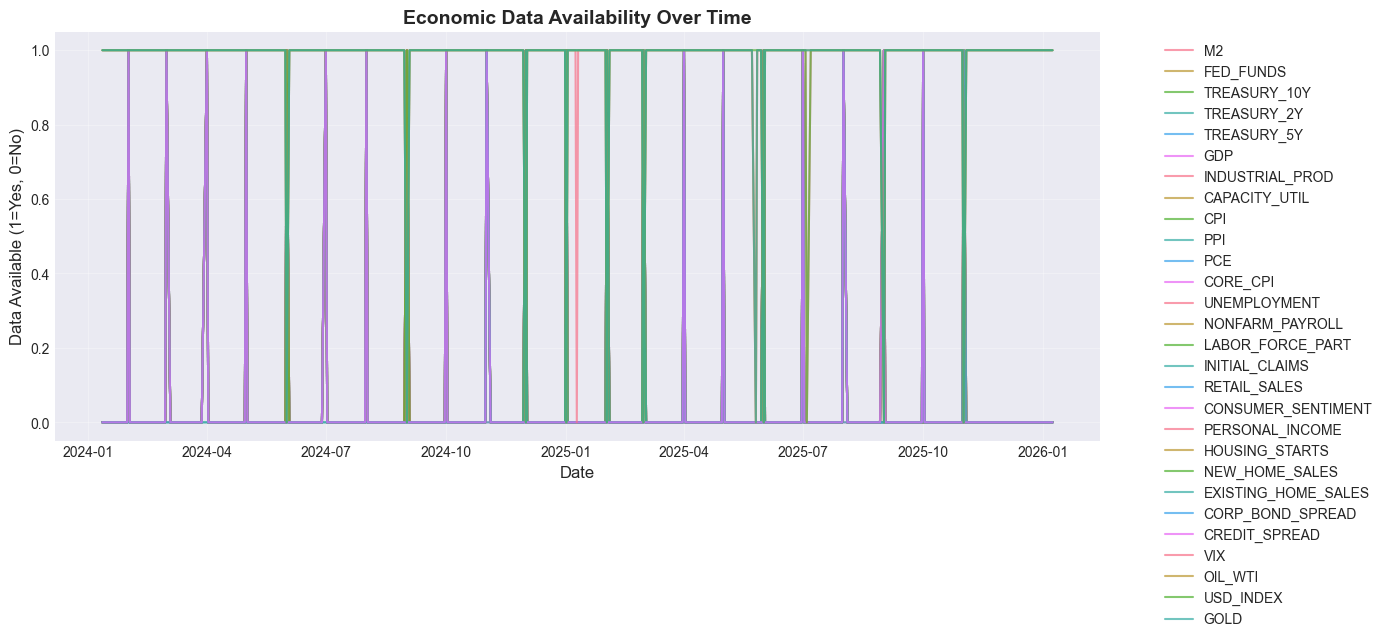

In [18]:
# Check data frequency and missing values
print("Missing values in economic data:")
missing_pct = (economic_data.isnull().sum() / len(economic_data) * 100).sort_values(ascending=False)
print(missing_pct)

# Visualize data availability
plt.figure(figsize=(14, 6))
for col in economic_data.columns:
    plt.plot(economic_data.index, economic_data[col].notna().astype(int), label=col, alpha=0.7)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Data Available (1=Yes, 0=No)', fontsize=12)
plt.title('Economic Data Availability Over Time', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# Forward fill missing values (economic data is often released monthly/quarterly)
economic_data_filled = economic_data.fillna(method='ffill')

# Calculate changes and growth rates
economic_features = economic_data_filled.copy()

# M2 growth rate (year-over-year)
if 'M2' in economic_features.columns:
    economic_features['M2_YoY_Growth'] = economic_features['M2'].pct_change(252) * 100
    economic_features['M2_QoQ_Growth'] = economic_features['M2'].pct_change(63) * 100

# Inflation rate (year-over-year CPI change)
if 'CPI' in economic_features.columns:
    economic_features['Inflation_YoY'] = economic_features['CPI'].pct_change(252) * 100

# Core inflation
if 'CORE_CPI' in economic_features.columns:
    economic_features['Core_Inflation_YoY'] = economic_features['CORE_CPI'].pct_change(252) * 100

# GDP growth (quarter-over-quarter)
if 'GDP' in economic_features.columns:
    economic_features['GDP_Growth'] = economic_features['GDP'].pct_change(63) * 100

# Industrial production growth
if 'INDUSTRIAL_PROD' in economic_features.columns:
    economic_features['Ind_Prod_Growth'] = economic_features['INDUSTRIAL_PROD'].pct_change(252) * 100

# Retail sales growth
if 'RETAIL_SALES' in economic_features.columns:
    economic_features['Retail_Sales_Growth'] = economic_features['RETAIL_SALES'].pct_change(252) * 100

# Yield curve slope (10Y - 2Y)
if 'TREASURY_10Y' in economic_features.columns and 'TREASURY_2Y' in economic_features.columns:
    economic_features['Yield_Curve_Slope'] = economic_features['TREASURY_10Y'] - economic_features['TREASURY_2Y']

# Credit spread (10Y - 5Y)
if 'TREASURY_10Y' in economic_features.columns and 'TREASURY_5Y' in economic_features.columns:
    economic_features['Yield_Curve_5Y10Y'] = economic_features['TREASURY_10Y'] - economic_features['TREASURY_5Y']

# Federal Funds Rate change
if 'FED_FUNDS' in economic_features.columns:
    economic_features['FED_FUNDS_Change'] = economic_features['FED_FUNDS'].diff()

# Oil price changes
if 'OIL_WTI' in economic_features.columns:
    economic_features['Oil_Return_1M'] = economic_features['OIL_WTI'].pct_change(21) * 100
    economic_features['Oil_Return_3M'] = economic_features['OIL_WTI'].pct_change(63) * 100

# USD Index changes
if 'USD_INDEX' in economic_features.columns:
    economic_features['USD_Return_1M'] = economic_features['USD_INDEX'].pct_change(21) * 100
    economic_features['USD_Return_3M'] = economic_features['USD_INDEX'].pct_change(63) * 100

# Gold price changes
if 'GOLD' in economic_features.columns:
    economic_features['Gold_Return_1M'] = economic_features['GOLD'].pct_change(21) * 100
    economic_features['Gold_Return_3M'] = economic_features['GOLD'].pct_change(63) * 100

# Housing momentum
if 'HOUSING_STARTS' in economic_features.columns:
    economic_features['Housing_Growth'] = economic_features['HOUSING_STARTS'].pct_change(63) * 100

# Consumer sentiment change
if 'CONSUMER_SENTIMENT' in economic_features.columns:
    economic_features['Sentiment_Change'] = economic_features['CONSUMER_SENTIMENT'].diff()

print("Economic features created:")
print(economic_features.columns.tolist())
print(f"\nShape: {economic_features.shape}")
economic_features.tail()

Economic features created:
['M2', 'FED_FUNDS', 'TREASURY_10Y', 'TREASURY_2Y', 'TREASURY_5Y', 'GDP', 'INDUSTRIAL_PROD', 'CAPACITY_UTIL', 'CPI', 'PPI', 'PCE', 'CORE_CPI', 'UNEMPLOYMENT', 'NONFARM_PAYROLL', 'LABOR_FORCE_PART', 'INITIAL_CLAIMS', 'RETAIL_SALES', 'CONSUMER_SENTIMENT', 'PERSONAL_INCOME', 'HOUSING_STARTS', 'NEW_HOME_SALES', 'EXISTING_HOME_SALES', 'CORP_BOND_SPREAD', 'CREDIT_SPREAD', 'VIX', 'OIL_WTI', 'USD_INDEX', 'GOLD', 'M2_YoY_Growth', 'M2_QoQ_Growth', 'Inflation_YoY', 'Core_Inflation_YoY', 'GDP_Growth', 'Ind_Prod_Growth', 'Retail_Sales_Growth', 'Yield_Curve_Slope', 'Yield_Curve_5Y10Y', 'FED_FUNDS_Change', 'Oil_Return_1M', 'Oil_Return_3M', 'USD_Return_1M', 'USD_Return_3M', 'Gold_Return_1M', 'Gold_Return_3M', 'Housing_Growth', 'Sentiment_Change']

Shape: (511, 46)


,M2,FED_FUNDS,TREASURY_10Y,TREASURY_2Y,TREASURY_5Y,GDP,INDUSTRIAL_PROD,CAPACITY_UTIL,CPI,PPI,...,Yield_Curve_5Y10Y,FED_FUNDS_Change,Oil_Return_1M,Oil_Return_3M,USD_Return_1M,USD_Return_3M,Gold_Return_1M,Gold_Return_3M,Housing_Growth,Sentiment_Change
2026-01-02,22322.4,3.88,4.12,3.55,3.68,31095.089,101.7935,75.9566,325.031,262.344,...,0.44,0.0,-2.251023,-5.847571,-0.946057,0.716329,3.052592,11.172950,0.0,0.0
2026-01-05,22322.4,3.88,4.12,3.55,3.68,31095.089,101.7935,75.9566,325.031,262.344,...,0.44,0.0,-1.068704,-5.462796,-0.586749,0.163078,5.658088,12.369252,0.0,0.0
2026-01-06,22322.4,3.88,4.12,3.55,3.68,31095.089,101.7935,75.9566,325.031,262.344,...,0.44,0.0,-4.256741,-7.451804,-0.414179,0.000000,6.420068,12.714381,0.0,0.0
2026-01-07,22322.4,3.88,4.12,3.55,3.68,31095.089,101.7935,75.9566,325.031,262.344,...,0.44,0.0,-6.807590,-10.487606,-0.313160,-0.171976,5.611334,10.041297,0.0,0.0
2026-01-08,22322.4,3.88,4.12,3.55,3.68,31095.089,101.7935,75.9566,325.031,262.344,...,0.44,0.0,-1.902179,-6.096570,-0.161465,-0.612820,6.269106,12.756256,0.0,0.0


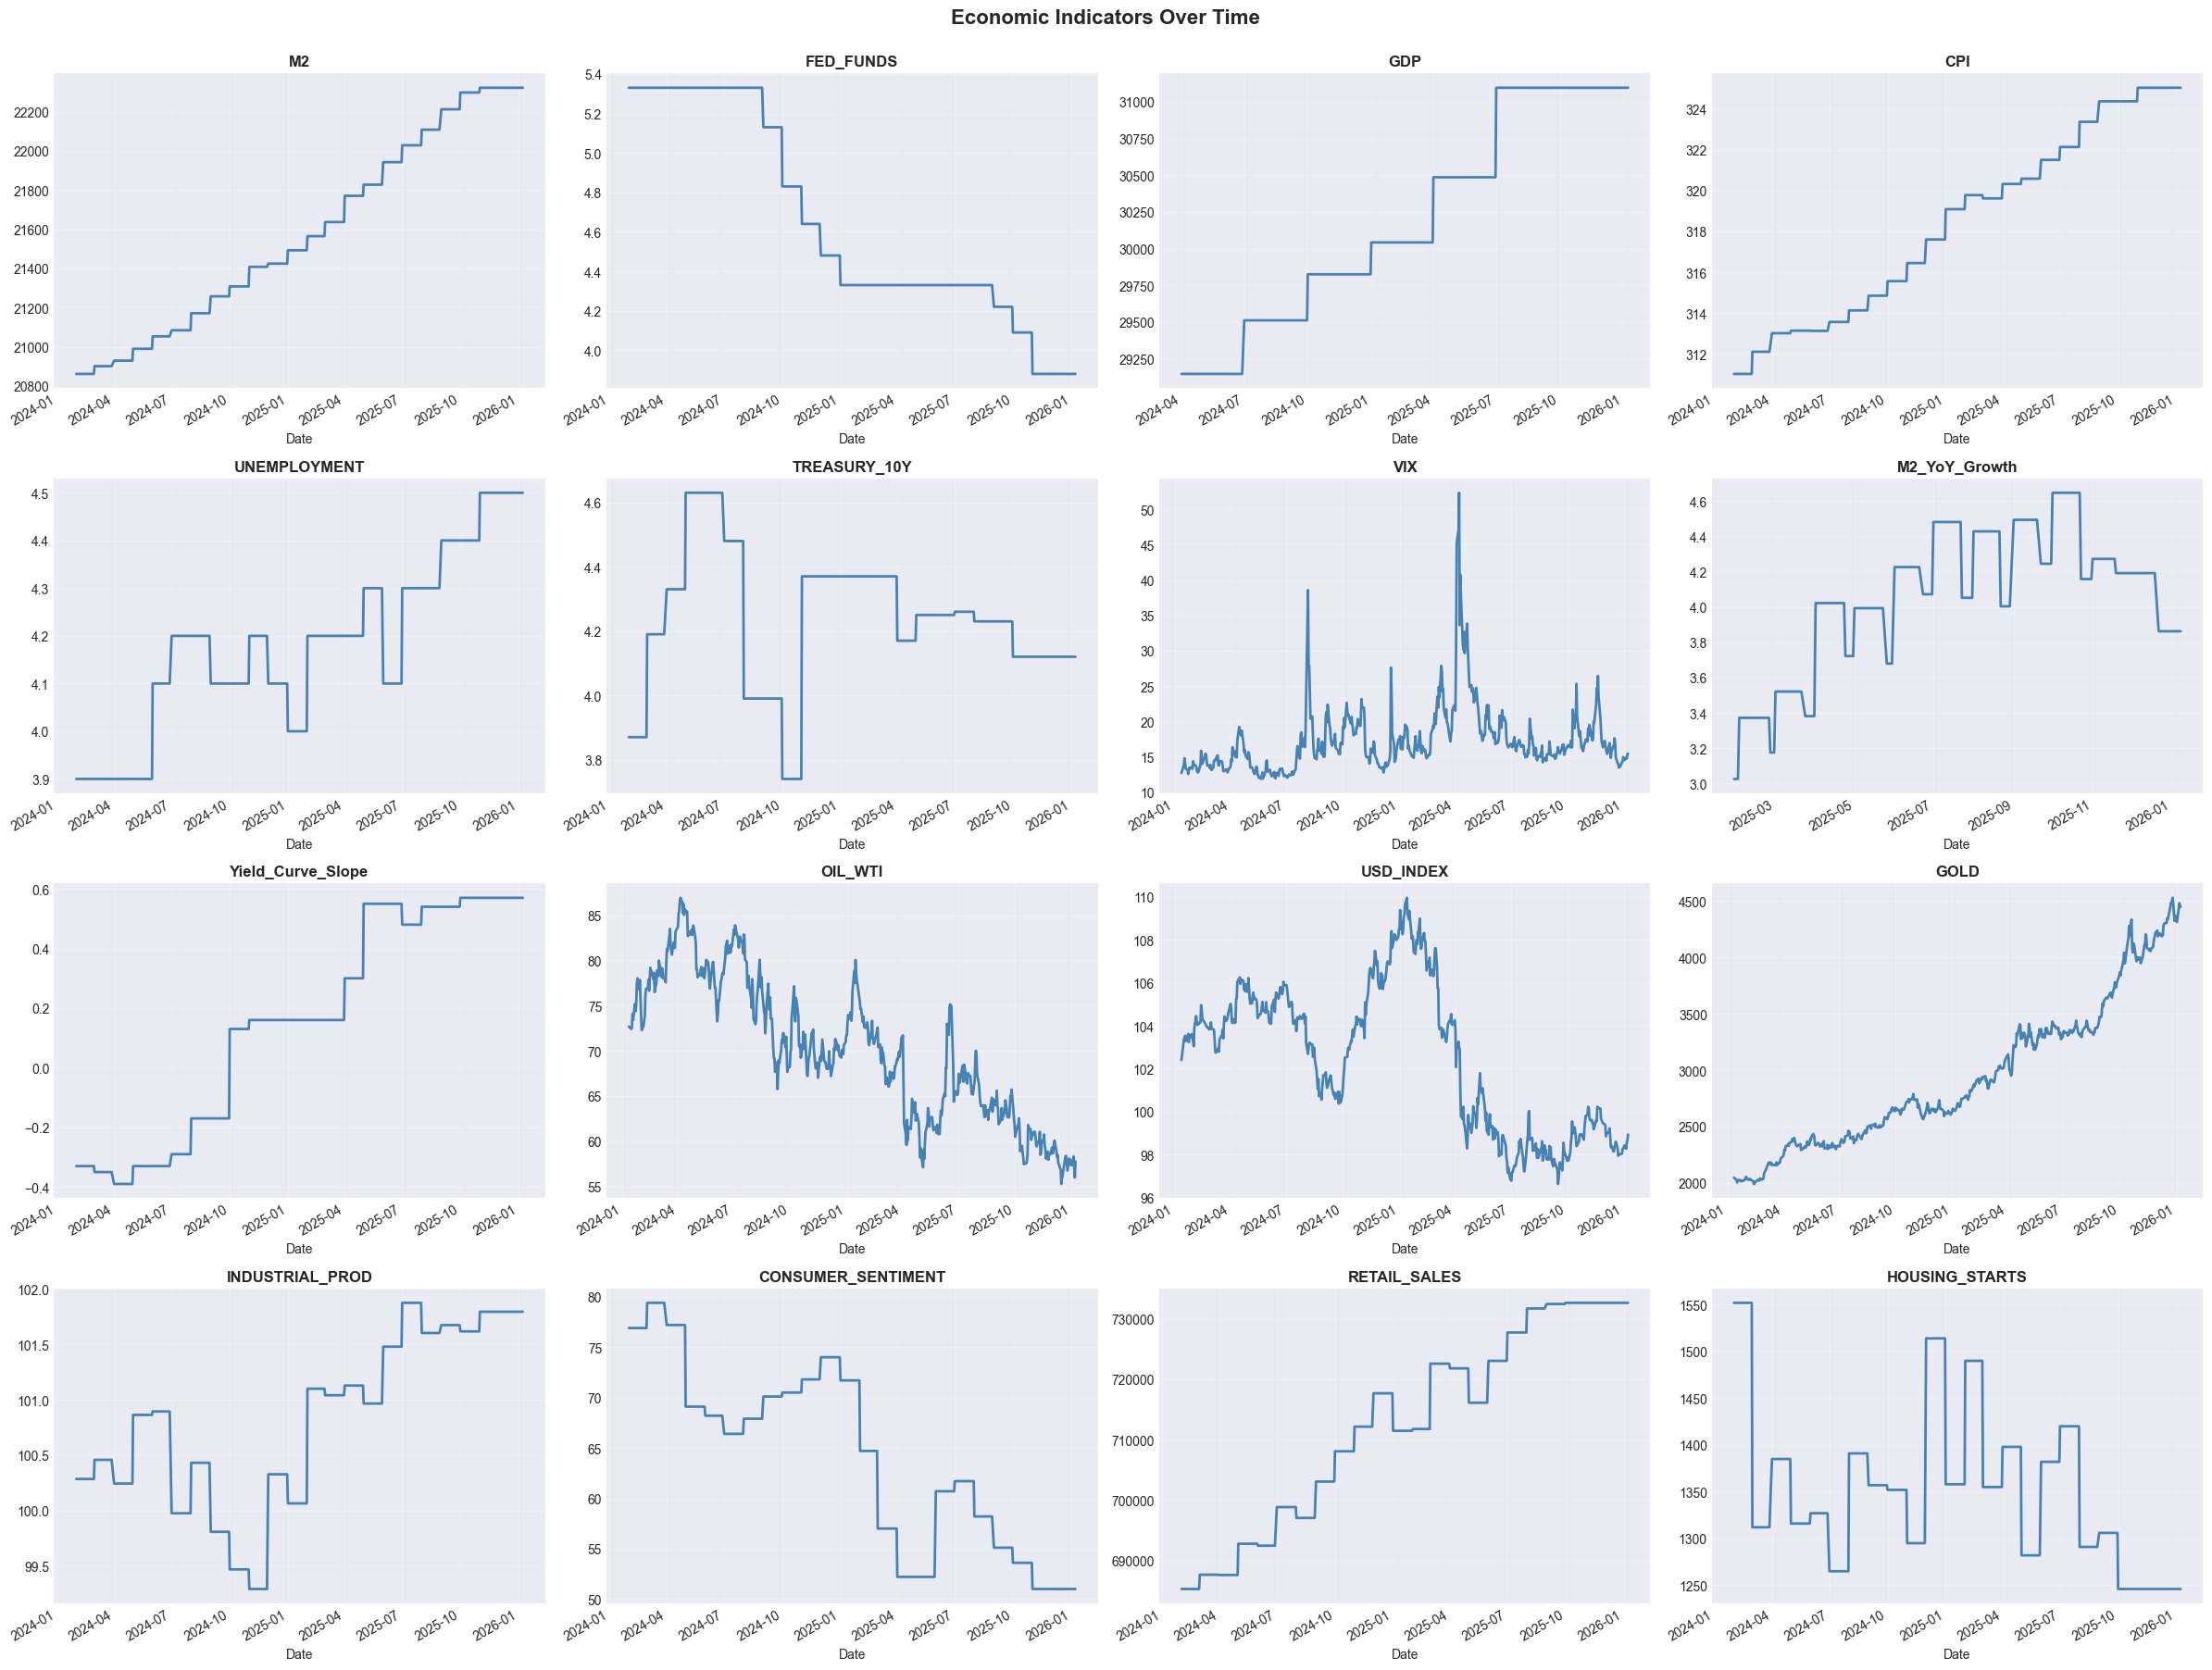

In [20]:
# Visualize economic indicators over time
fig, axes = plt.subplots(4, 4, figsize=(24, 18))
axes = axes.flatten()

indicators_to_plot = ['M2', 'FED_FUNDS', 'GDP', 'CPI', 'UNEMPLOYMENT', 
                      'TREASURY_10Y', 'VIX', 'M2_YoY_Growth', 'Yield_Curve_Slope',
                      'OIL_WTI', 'USD_INDEX', 'GOLD', 'INDUSTRIAL_PROD',
                      'CONSUMER_SENTIMENT', 'RETAIL_SALES', 'HOUSING_STARTS']

for idx, indicator in enumerate(indicators_to_plot):
    if idx < len(axes) and indicator in economic_features.columns:
        ax = axes[idx]
        economic_features[indicator].plot(ax=ax, linewidth=2, color='steelblue')
        ax.set_title(indicator, fontsize=12, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(indicators_to_plot), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Economic Indicators Over Time', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 5. Align Stock and Economic Data

In [21]:
# Calculate stock returns (monthly and daily)
stock_returns_daily = adj_close.pct_change()
stock_returns_monthly = adj_close.resample('MS').last().pct_change()

# Calculate sector returns
sector_returns_daily = sector_index_df.pct_change()
sector_returns_monthly = sector_index_df.resample('MS').last().pct_change()

print(f"Daily stock returns shape: {stock_returns_daily.shape}")
print(f"Monthly stock returns shape: {stock_returns_monthly.shape}")
print(f"Daily sector returns shape: {sector_returns_daily.shape}")
print(f"Monthly sector returns shape: {sector_returns_monthly.shape}")

Daily stock returns shape: (500, 301)
Monthly stock returns shape: (25, 301)
Daily sector returns shape: (500, 5)
Monthly sector returns shape: (25, 5)


In [22]:
# Resample economic data to monthly frequency for easier analysis
economic_monthly = economic_features.resample('MS').last()

# Align dates between stock returns and economic data
common_dates = stock_returns_monthly.index.intersection(economic_monthly.index)
print(f"Common dates for analysis: {len(common_dates)}")
print(f"Date range: {common_dates[0]} to {common_dates[-1]}")

# Create aligned datasets
stock_returns_aligned = stock_returns_monthly.loc[common_dates]
sector_returns_aligned = sector_returns_monthly.loc[common_dates]
economic_aligned = economic_monthly.loc[common_dates]

print(f"\nAligned stock returns: {stock_returns_aligned.shape}")
print(f"Aligned sector returns: {sector_returns_aligned.shape}")
print(f"Aligned economic data: {economic_aligned.shape}")

Common dates for analysis: 25
Date range: 2024-01-01 00:00:00 to 2026-01-01 00:00:00

Aligned stock returns: (25, 301)
Aligned sector returns: (25, 5)
Aligned economic data: (25, 46)


## 6. Correlation Analysis: Economic Factors vs Stock Returns

In [23]:
# Calculate average market return (equal-weighted)
market_return = stock_returns_aligned.mean(axis=1)
market_return.name = 'Market_Return'

# Combine market return with economic data
analysis_df = pd.concat([market_return, economic_aligned], axis=1)

# Check for NaN values before dropping
print("NaN counts before cleaning:")
print(analysis_df.isnull().sum())
print(f"\nOriginal shape: {analysis_df.shape}")

# Only drop rows where Market_Return is NaN (keep rows with some economic data missing)
analysis_df = analysis_df[analysis_df['Market_Return'].notna()]

# For remaining columns, fill forward any missing economic data
analysis_df = analysis_df.fillna(method='ffill').fillna(method='bfill')

print(f"\nAfter cleaning shape: {analysis_df.shape}")
print(f"Months of data: {len(analysis_df)}")
print("\nNaN counts after cleaning:")
print(analysis_df.isnull().sum())
print("\nFirst few rows:")
analysis_df.head()

NaN counts before cleaning:
Market_Return           1
M2                      1
FED_FUNDS               1
TREASURY_10Y            1
TREASURY_2Y             1
TREASURY_5Y             1
GDP                     3
INDUSTRIAL_PROD         1
CAPACITY_UTIL           1
CPI                     1
PPI                     1
PCE                     1
CORE_CPI                1
UNEMPLOYMENT            1
NONFARM_PAYROLL         1
LABOR_FORCE_PART        1
INITIAL_CLAIMS          5
RETAIL_SALES            1
CONSUMER_SENTIMENT      1
PERSONAL_INCOME         1
HOUSING_STARTS          1
NEW_HOME_SALES          1
EXISTING_HOME_SALES    10
CORP_BOND_SPREAD        1
CREDIT_SPREAD           1
VIX                     0
OIL_WTI                 0
USD_INDEX               0
GOLD                    0
M2_YoY_Growth          12
M2_QoQ_Growth           4
Inflation_YoY          12
Core_Inflation_YoY     12
GDP_Growth              5
Ind_Prod_Growth        12
Retail_Sales_Growth    12
Yield_Curve_Slope       1
Yield_Curv

,Market_Return,M2,FED_FUNDS,TREASURY_10Y,TREASURY_2Y,TREASURY_5Y,GDP,INDUSTRIAL_PROD,CAPACITY_UTIL,CPI,...,Yield_Curve_5Y10Y,FED_FUNDS_Change,Oil_Return_1M,Oil_Return_3M,USD_Return_1M,USD_Return_3M,Gold_Return_1M,Gold_Return_3M,Housing_Growth,Sentiment_Change
2024-02-01,0.053696,20861.2,5.33,3.87,4.20,3.80,29147.044,100.2850,76.5157,311.022,...,0.07,0.0,0.565410,5.281419,0.735012,2.727272,0.698988,12.793498,0.304878,0.0
2024-03-01,0.039898,20900.9,5.33,4.19,4.54,4.17,29147.044,100.4575,76.5964,312.107,...,0.02,0.0,5.895082,5.281419,0.548182,2.727272,9.070335,12.793498,0.304878,0.0
2024-04-01,-0.056542,20929.0,5.33,4.33,4.72,4.34,29147.044,100.2434,76.3803,313.016,...,-0.01,0.0,-2.126387,5.281419,1.142644,2.727272,2.454724,12.793498,0.304878,0.0
2024-05-01,0.028992,20989.5,5.33,4.63,4.96,4.64,29147.044,100.8630,76.7961,313.140,...,-0.01,0.0,-2.544307,-3.726402,-1.030639,0.779894,1.000044,11.308640,0.304878,0.0
2024-06-01,0.004462,21053.0,5.33,4.63,4.96,4.64,29147.044,100.8940,76.7586,313.131,...,-0.01,0.0,4.659218,-2.592281,1.098168,0.809375,-0.648767,4.077798,-4.187726,0.0


Correlation with Market Returns:
Market_Return          1.000000
CREDIT_SPREAD          0.350665
CORP_BOND_SPREAD       0.341967
INITIAL_CLAIMS         0.198745
GDP_Growth             0.188892
Yield_Curve_5Y10Y      0.156793
Inflation_YoY          0.094399
FED_FUNDS              0.072766
M2_YoY_Growth          0.063901
Oil_Return_1M          0.060758
Yield_Curve_Slope      0.056541
UNEMPLOYMENT           0.053396
GDP                    0.038763
GOLD                   0.021773
M2                     0.020344
PPI                    0.017565
Core_Inflation_YoY     0.010044
NEW_HOME_SALES        -0.008511
Ind_Prod_Growth       -0.015106
CONSUMER_SENTIMENT    -0.018112
CORE_CPI              -0.026469
CPI                   -0.032336
LABOR_FORCE_PART      -0.042059
PCE                   -0.049838
PERSONAL_INCOME       -0.060339
INDUSTRIAL_PROD       -0.074647
RETAIL_SALES          -0.074978
TREASURY_10Y          -0.077313
TREASURY_2Y           -0.080961
Gold_Return_1M        -0.081094
OIL_WTI

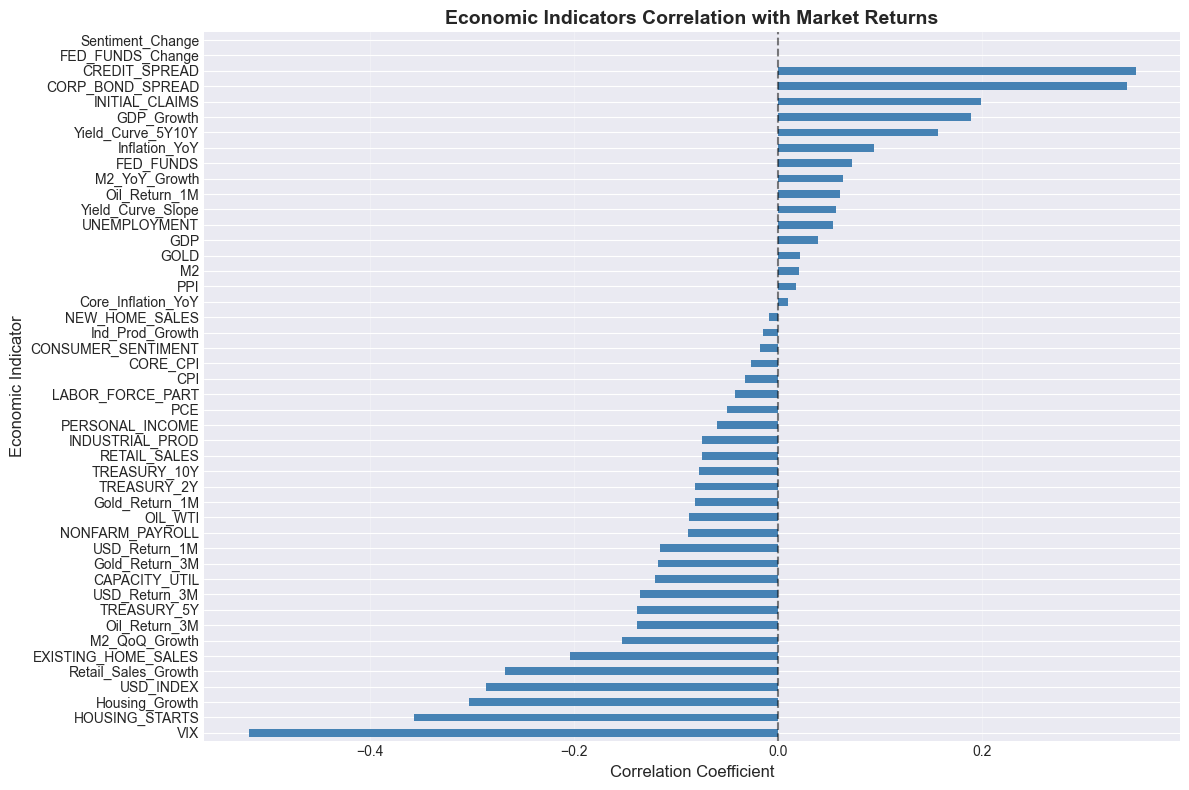

In [24]:
# Calculate correlations between economic factors and market returns
correlations = analysis_df.corr()['Market_Return'].sort_values(ascending=False)

print("Correlation with Market Returns:")
print(correlations)
print("\n" + "="*60)
print("Top Positive Correlations:")
print(correlations.drop('Market_Return').head(5))
print("\nTop Negative Correlations:")
print(correlations.drop('Market_Return').tail(5))
print("="*60)

# Visualize correlations
plt.figure(figsize=(12, 8))
correlations.drop('Market_Return').sort_values().plot(kind='barh', color='steelblue')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Economic Indicator', fontsize=12)
plt.title('Economic Indicators Correlation with Market Returns', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

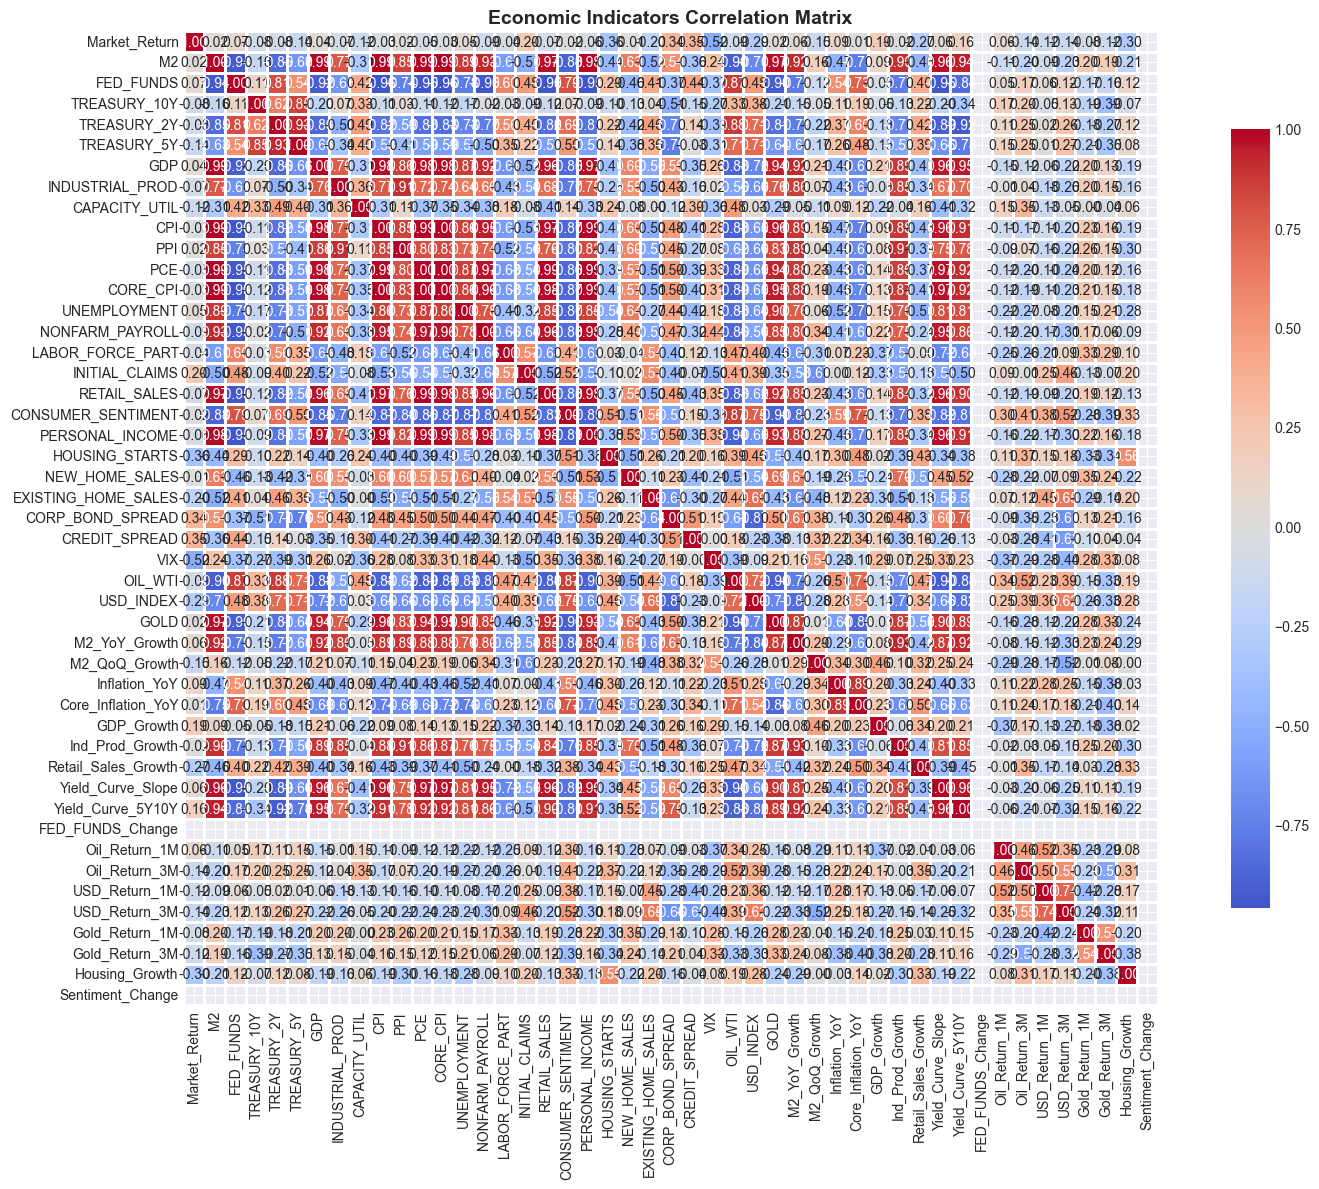

In [25]:
# Full correlation heatmap
plt.figure(figsize=(16, 12))
correlation_matrix = analysis_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Economic Indicators Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Sector-Specific Analysis

In [26]:
# Analyze how each sector responds to economic factors
sector_correlations = {}

for sector in sector_returns_aligned.columns:
    sector_df = pd.concat([sector_returns_aligned[sector], economic_aligned], axis=1)
    
    # Only drop rows where sector return is NaN, then fill economic data
    sector_df = sector_df[sector_df[sector].notna()]
    sector_df = sector_df.fillna(method='ffill').fillna(method='bfill')
    
    if len(sector_df) > 10:  # Need at least 10 data points for correlation
        corr = sector_df.corr()[sector].drop(sector)
        sector_correlations[sector] = corr
        print(f"{sector}: {len(sector_df)} data points")

sector_corr_df = pd.DataFrame(sector_correlations)
print("\nSector correlations with economic factors:")
print(sector_corr_df.round(3))

XLK: 24 data points
XLV: 24 data points
XLF: 24 data points
XLI: 24 data points
XLY: 24 data points

Sector correlations with economic factors:
                       XLK    XLV    XLF    XLI    XLY
M2                  -0.001  0.167 -0.118 -0.051 -0.149
FED_FUNDS            0.117 -0.072  0.161  0.125  0.243
TREASURY_10Y         0.062  0.128 -0.009 -0.212 -0.111
TREASURY_2Y          0.013 -0.011  0.054 -0.093  0.053
TREASURY_5Y         -0.015  0.011  0.004 -0.197 -0.065
GDP                 -0.027  0.152 -0.100 -0.011 -0.119
INDUSTRIAL_PROD      0.027  0.203 -0.264 -0.181 -0.147
CAPACITY_UTIL        0.078  0.071 -0.220 -0.178  0.012
CPI                 -0.060  0.147 -0.154 -0.110 -0.200
PPI                 -0.016  0.280 -0.132 -0.050 -0.156
PCE                 -0.067  0.105 -0.155 -0.118 -0.188
CORE_CPI            -0.057  0.128 -0.138 -0.097 -0.183
UNEMPLOYMENT        -0.025  0.148  0.046  0.022 -0.026
NONFARM_PAYROLL     -0.085  0.029 -0.169 -0.130 -0.198
LABOR_FORCE_PART     0.007  0.1

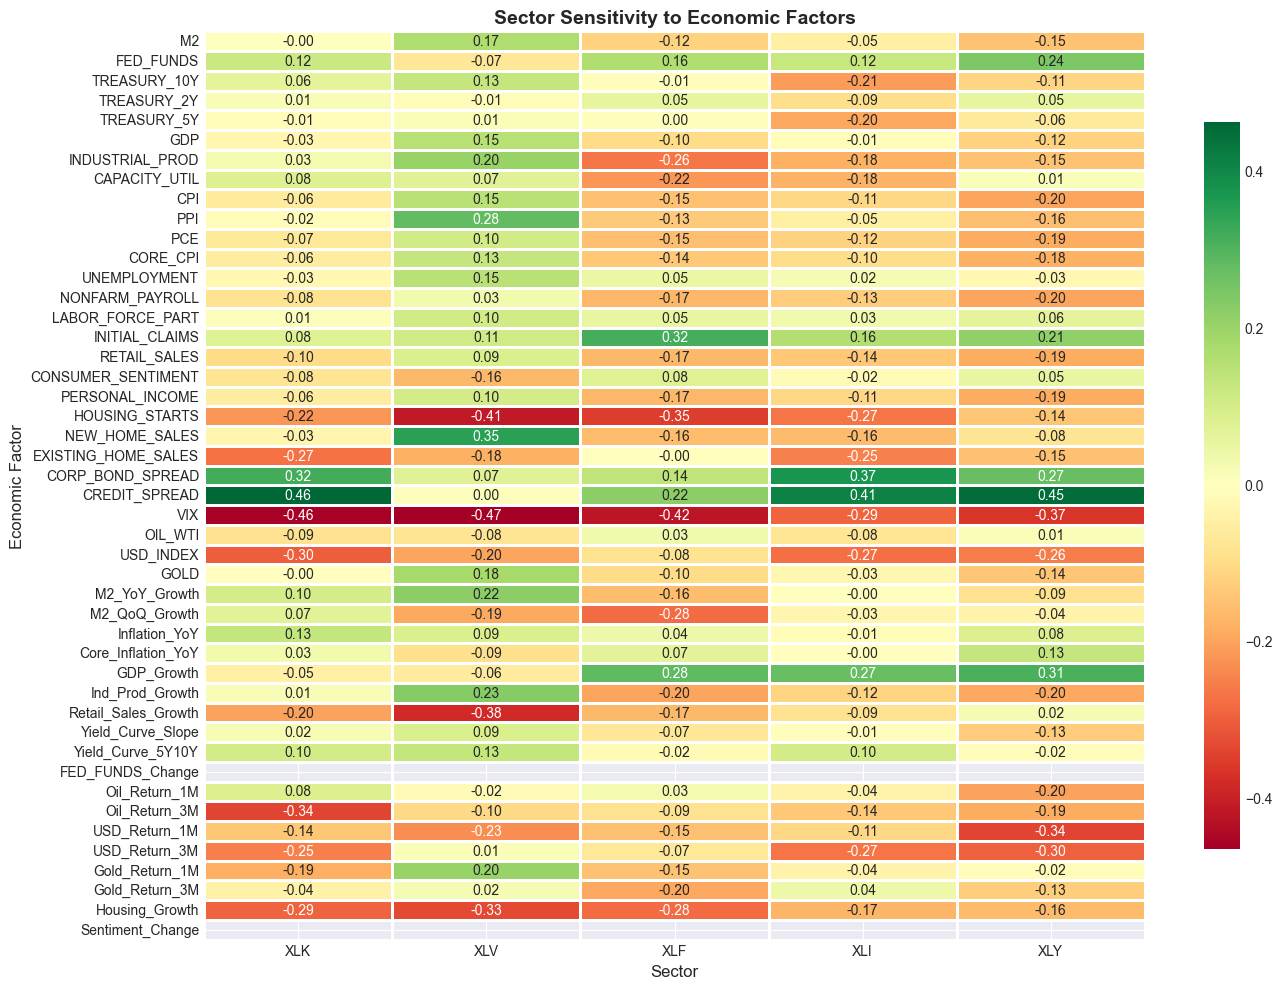

In [27]:
# Heatmap of sector sensitivities to economic factors
plt.figure(figsize=(14, 10))
sns.heatmap(sector_corr_df, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Sector Sensitivity to Economic Factors', fontsize=14, fontweight='bold')
plt.xlabel('Sector', fontsize=12)
plt.ylabel('Economic Factor', fontsize=12)
plt.tight_layout()
plt.show()

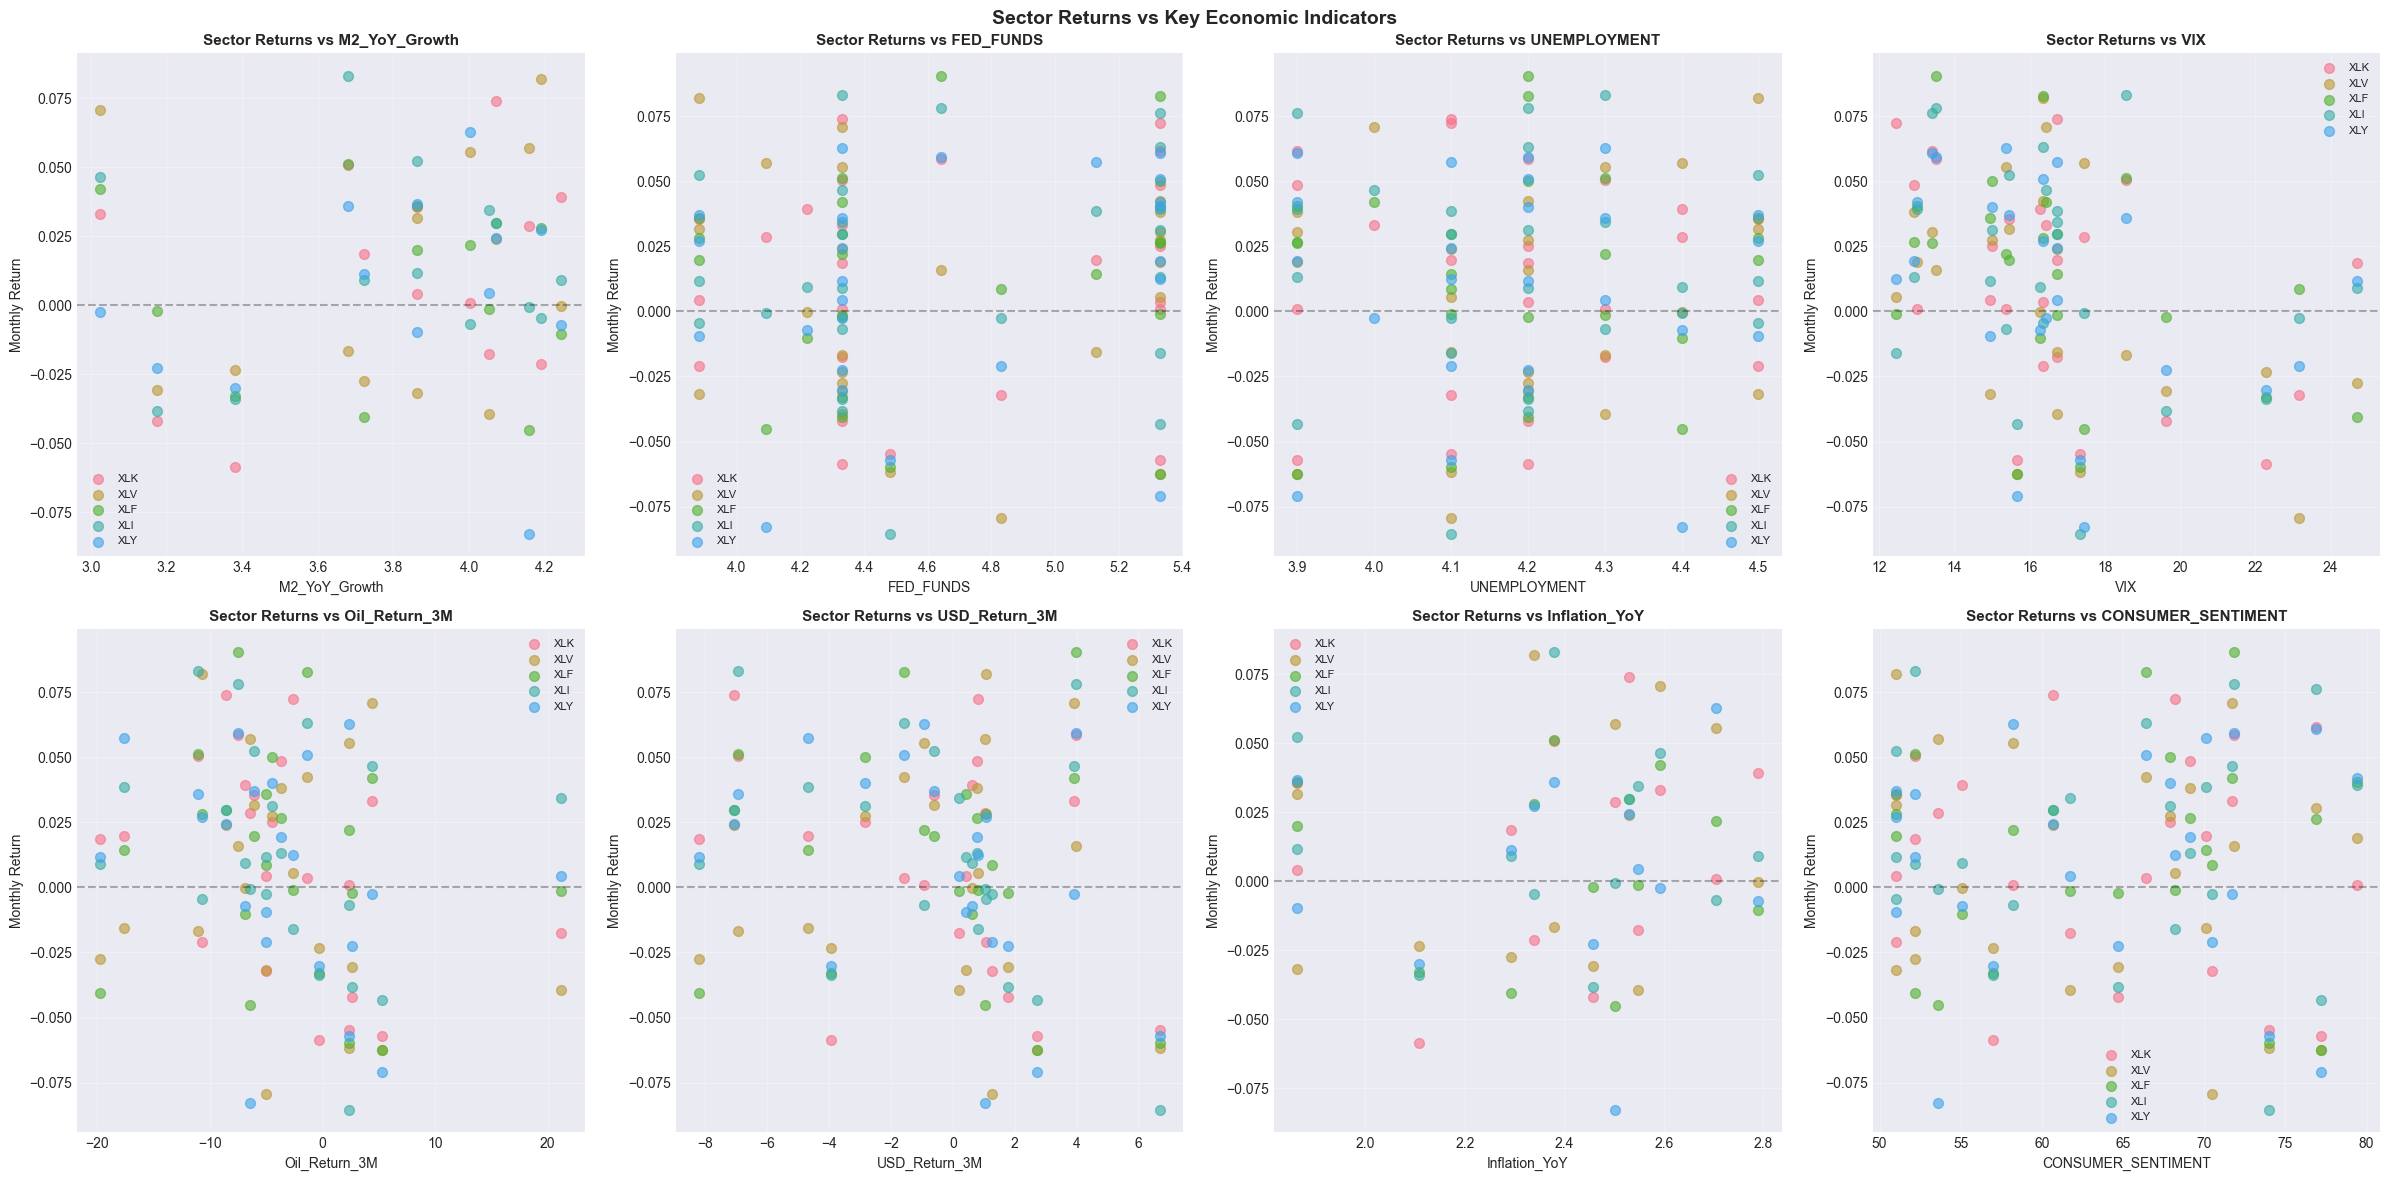

In [28]:
# Plot sector returns vs key economic indicators
key_indicators = ['M2_YoY_Growth', 'FED_FUNDS', 'UNEMPLOYMENT', 'VIX', 
                  'Oil_Return_3M', 'USD_Return_3M', 'Inflation_YoY', 'CONSUMER_SENTIMENT']
available_indicators = [ind for ind in key_indicators if ind in economic_aligned.columns]

if available_indicators:
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.flatten()
    
    for idx, indicator in enumerate(available_indicators[:8]):
        ax = axes[idx]
        
        for sector in sector_returns_aligned.columns:
            # Create temporary dataframe for this sector and indicator
            temp_df = pd.concat([sector_returns_aligned[sector], economic_aligned[indicator]], axis=1)
            
            # Only drop rows where sector or indicator is NaN
            temp_df = temp_df.dropna(subset=[sector, indicator])
            
            if len(temp_df) > 0:
                ax.scatter(temp_df[indicator], temp_df[sector], 
                          label=sector, alpha=0.6, s=50)
        
        ax.set_xlabel(indicator, fontsize=10)
        ax.set_ylabel('Monthly Return', fontsize=10)
        ax.set_title(f'Sector Returns vs {indicator}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(available_indicators), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Sector Returns vs Key Economic Indicators', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 8. Comprehensive Economic Factor Coverage Analysis

In [29]:
# Categorize economic indicators by type
economic_categories = {
    'Monetary Policy': ['M2', 'FED_FUNDS', 'TREASURY_10Y', 'TREASURY_2Y', 'TREASURY_5Y', 
                        'M2_YoY_Growth', 'M2_QoQ_Growth', 'FED_FUNDS_Change',
                        'Yield_Curve_Slope', 'Yield_Curve_5Y10Y'],
    
    'Economic Growth': ['GDP', 'INDUSTRIAL_PROD', 'CAPACITY_UTIL', 'GDP_Growth', 'Ind_Prod_Growth'],
    
    'Inflation': ['CPI', 'PPI', 'PCE', 'CORE_CPI', 'Inflation_YoY', 'Core_Inflation_YoY'],
    
    'Labor Market': ['UNEMPLOYMENT', 'NONFARM_PAYROLL', 'LABOR_FORCE_PART', 'INITIAL_CLAIMS'],
    
    'Consumer Activity': ['RETAIL_SALES', 'CONSUMER_SENTIMENT', 'PERSONAL_INCOME', 
                          'Retail_Sales_Growth', 'Sentiment_Change'],
    
    'Housing Market': ['HOUSING_STARTS', 'NEW_HOME_SALES', 'EXISTING_HOME_SALES', 'Housing_Growth'],
    
    'Credit Markets': ['CORP_BOND_SPREAD', 'CREDIT_SPREAD'],
    
    'Commodities & FX': ['OIL_WTI', 'USD_INDEX', 'GOLD', 
                         'Oil_Return_1M', 'Oil_Return_3M',
                         'USD_Return_1M', 'USD_Return_3M',
                         'Gold_Return_1M', 'Gold_Return_3M'],
    
    'Market Volatility': ['VIX']
}

# Count available indicators by category
print("=" * 80)
print("ECONOMIC FACTOR COVERAGE SUMMARY")
print("=" * 80)

total_available = 0
total_indicators = 0

for category, indicators in economic_categories.items():
    available = [ind for ind in indicators if ind in economic_features.columns]
    missing = [ind for ind in indicators if ind not in economic_features.columns]
    
    total_indicators += len(indicators)
    total_available += len(available)
    
    print(f"\n{category}:")
    print(f"  Available: {len(available)}/{len(indicators)}")
    
    if available:
        print(f"  {', '.join(available)}")
    
    if missing:
        print(f"  Missing: {', '.join(missing)}")

print("\n" + "=" * 80)
print(f"TOTAL COVERAGE: {total_available}/{total_indicators} indicators ({total_available/total_indicators*100:.1f}%)")
print("=" * 80)

# Show data availability statistics
print("\n\nDATA AVAILABILITY STATISTICS:")
print("-" * 80)
availability = {}
for col in economic_features.columns:
    non_null = economic_features[col].notna().sum()
    total = len(economic_features)
    availability[col] = (non_null / total) * 100

availability_df = pd.DataFrame(list(availability.items()), columns=['Indicator', 'Availability_%'])
availability_df = availability_df.sort_values('Availability_%', ascending=False)
print(availability_df.to_string(index=False))

ECONOMIC FACTOR COVERAGE SUMMARY

Monetary Policy:
  Available: 10/10
  M2, FED_FUNDS, TREASURY_10Y, TREASURY_2Y, TREASURY_5Y, M2_YoY_Growth, M2_QoQ_Growth, FED_FUNDS_Change, Yield_Curve_Slope, Yield_Curve_5Y10Y

Economic Growth:
  Available: 5/5
  GDP, INDUSTRIAL_PROD, CAPACITY_UTIL, GDP_Growth, Ind_Prod_Growth

Inflation:
  Available: 6/6
  CPI, PPI, PCE, CORE_CPI, Inflation_YoY, Core_Inflation_YoY

Labor Market:
  Available: 4/4
  UNEMPLOYMENT, NONFARM_PAYROLL, LABOR_FORCE_PART, INITIAL_CLAIMS

Consumer Activity:
  Available: 5/5
  RETAIL_SALES, CONSUMER_SENTIMENT, PERSONAL_INCOME, Retail_Sales_Growth, Sentiment_Change

Housing Market:
  Available: 4/4
  HOUSING_STARTS, NEW_HOME_SALES, EXISTING_HOME_SALES, Housing_Growth

Credit Markets:
  Available: 2/2
  CORP_BOND_SPREAD, CREDIT_SPREAD

Commodities & FX:
  Available: 9/9
  OIL_WTI, USD_INDEX, GOLD, Oil_Return_1M, Oil_Return_3M, USD_Return_1M, USD_Return_3M, Gold_Return_1M, Gold_Return_3M

Market Volatility:
  Available: 1/1
  VIX


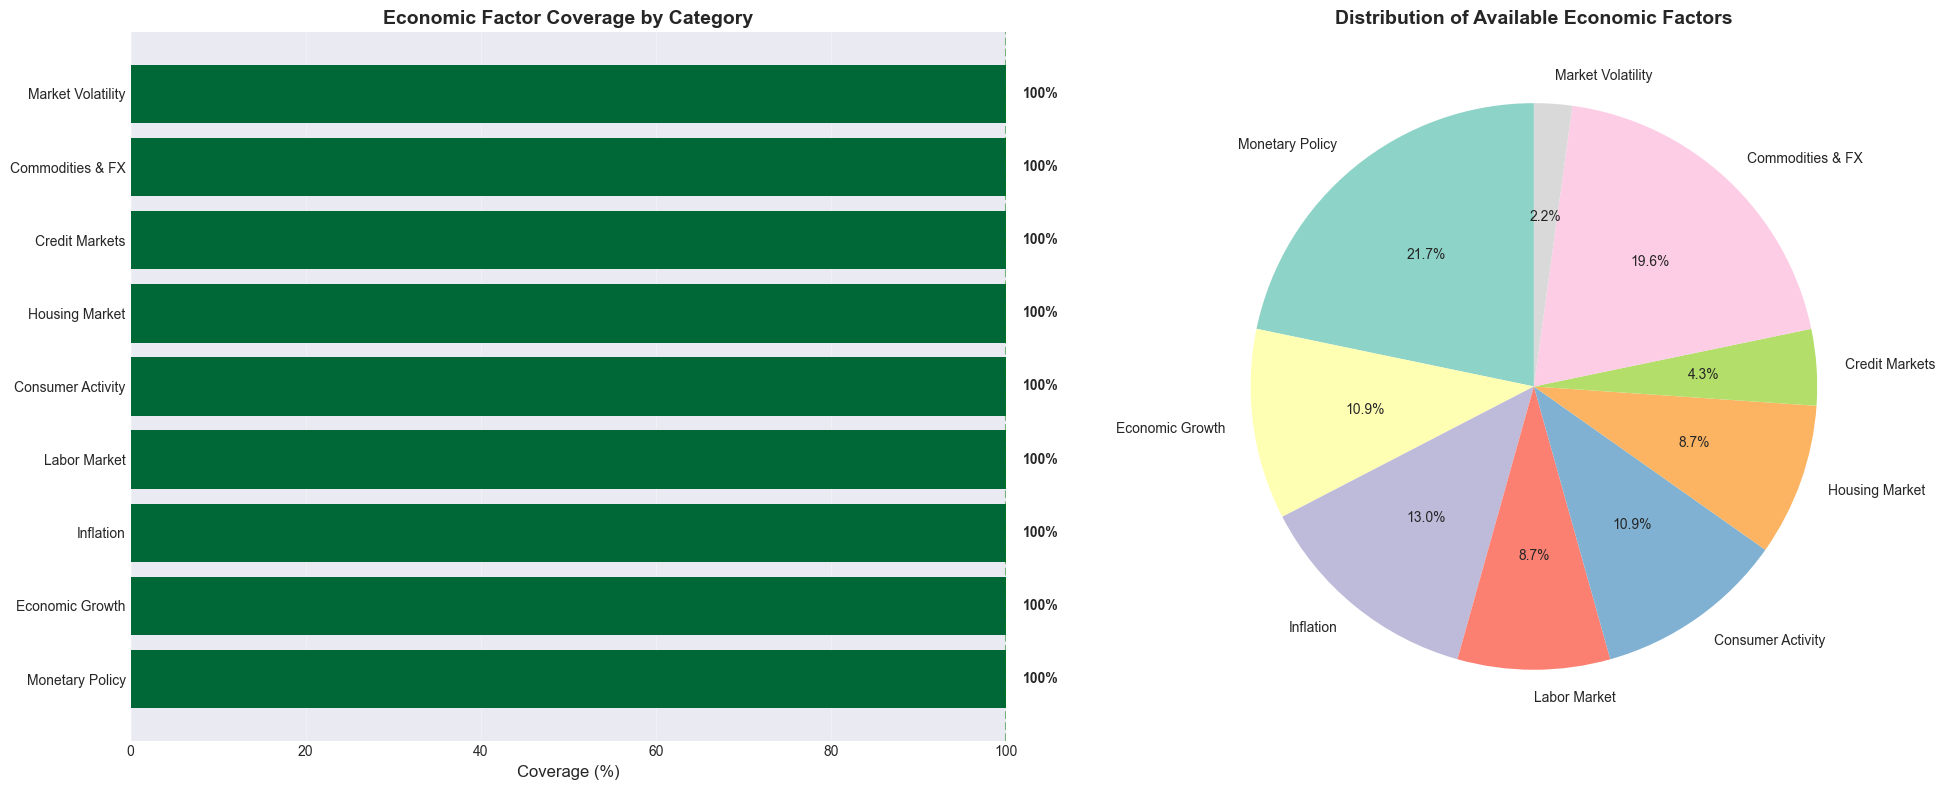

In [30]:
# Visualize data coverage by category
category_coverage = {}
for category, indicators in economic_categories.items():
    available = len([ind for ind in indicators if ind in economic_features.columns])
    total = len(indicators)
    category_coverage[category] = (available / total) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Bar chart of coverage by category
categories = list(category_coverage.keys())
coverage_pct = list(category_coverage.values())
colors = plt.cm.RdYlGn([c/100 for c in coverage_pct])

ax1.barh(categories, coverage_pct, color=colors)
ax1.set_xlabel('Coverage (%)', fontsize=12)
ax1.set_title('Economic Factor Coverage by Category', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 100)
ax1.axvline(x=100, color='green', linestyle='--', alpha=0.5, label='100% Coverage')
ax1.grid(True, alpha=0.3, axis='x')

for i, (cat, pct) in enumerate(zip(categories, coverage_pct)):
    ax1.text(pct + 2, i, f'{pct:.0f}%', va='center', fontweight='bold')

# Pie chart of total factor distribution
category_counts = {cat: len([ind for ind in indicators if ind in economic_features.columns]) 
                   for cat, indicators in economic_categories.items()}
category_counts = {k: v for k, v in category_counts.items() if v > 0}

ax2.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%',
        startangle=90, colors=plt.cm.Set3(range(len(category_counts))))
ax2.set_title('Distribution of Available Economic Factors', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

CROSS-CATEGORY CORRELATIONS


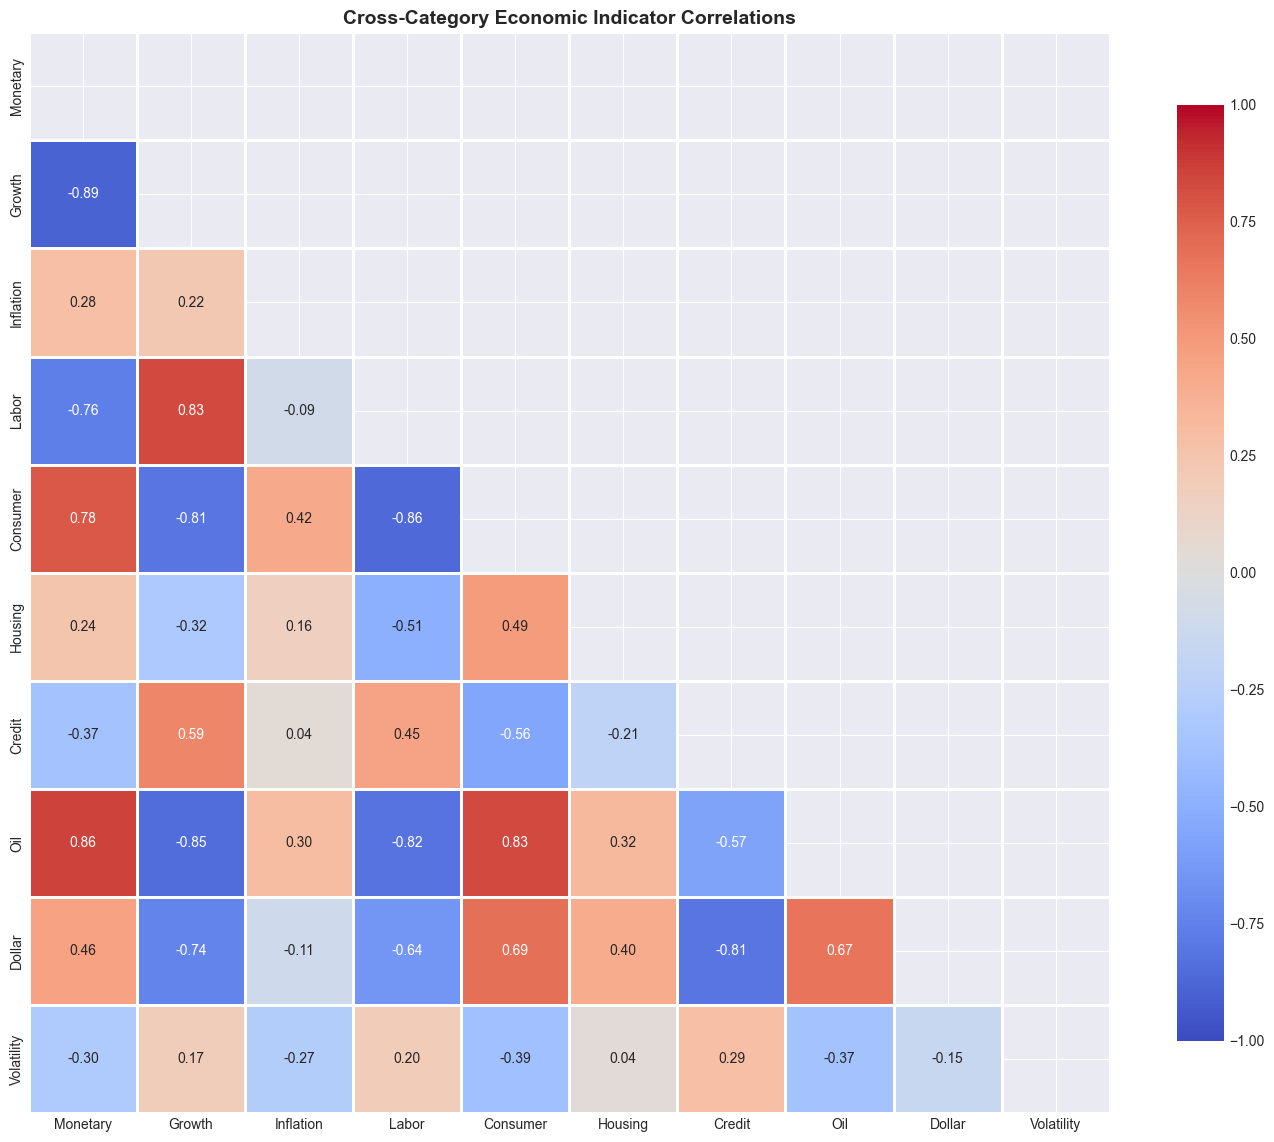


STRONGEST POSITIVE CORRELATIONS:
1. Monetary <-> Growth: -0.892
2. Labor <-> Consumer: -0.860
3. Monetary <-> Oil: 0.859
4. Growth <-> Oil: -0.850
5. Consumer <-> Oil: 0.833
6. Growth <-> Labor: 0.833
7. Labor <-> Oil: -0.817
8. Credit <-> Dollar: -0.810
9. Growth <-> Consumer: -0.810
10. Monetary <-> Consumer: 0.776


In [31]:
# Analyze correlations between different economic factor categories
print("CROSS-CATEGORY CORRELATIONS")
print("=" * 80)

# Select key representatives from each category
key_indicators = {
    'Monetary': 'FED_FUNDS',
    'Growth': 'GDP',
    'Inflation': 'Inflation_YoY',
    'Labor': 'UNEMPLOYMENT',
    'Consumer': 'CONSUMER_SENTIMENT',
    'Housing': 'HOUSING_STARTS',
    'Credit': 'CORP_BOND_SPREAD',
    'Oil': 'OIL_WTI',
    'Dollar': 'USD_INDEX',
    'Volatility': 'VIX'
}

# Filter to only available indicators
available_key = {name: ind for name, ind in key_indicators.items() 
                 if ind in economic_features.columns}

if len(available_key) > 1:
    key_data = economic_features[[ind for ind in available_key.values()]].copy()
    key_data.columns = list(available_key.keys())
    
    # Calculate correlation matrix
    key_corr = key_data.corr()
    
    # Visualize
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(key_corr, dtype=bool))
    sns.heatmap(key_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1)
    plt.title('Cross-Category Economic Indicator Correlations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print strongest correlations
    print("\nSTRONGEST POSITIVE CORRELATIONS:")
    corr_pairs = []
    for i in range(len(key_corr.columns)):
        for j in range(i+1, len(key_corr.columns)):
            corr_pairs.append((key_corr.columns[i], key_corr.columns[j], key_corr.iloc[i, j]))
    
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for i, (ind1, ind2, corr) in enumerate(corr_pairs[:10]):
        print(f"{i+1}. {ind1} <-> {ind2}: {corr:.3f}")
else:
    print("Not enough key indicators available for cross-category analysis")

## 9. Statistical Significance Analysis: Which Factors Actually Impact Stock Prices?

In [32]:
# Statistical significance testing using correlation p-values
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("STATISTICAL SIGNIFICANCE OF ECONOMIC FACTORS")
print("="*80)

# Calculate correlations and p-values for each economic factor with market returns
significance_results = []

for col in analysis_df.columns:
    if col != 'Market_Return':
        # Remove NaN values for this pair
        temp_df = analysis_df[['Market_Return', col]].dropna()
        
        if len(temp_df) > 3:  # Need at least a few points for correlation
            corr, p_value = stats.pearsonr(temp_df['Market_Return'], temp_df[col])
            significance_results.append({
                'Factor': col,
                'Correlation': corr,
                'P-Value': p_value,
                'Significant': 'Yes' if p_value < 0.05 else 'No',
                'Abs_Correlation': abs(corr),
                'Sample_Size': len(temp_df)
            })

# Create DataFrame and sort by absolute correlation
sig_df = pd.DataFrame(significance_results)
sig_df = sig_df.sort_values('Abs_Correlation', ascending=False)

# Display statistically significant factors (p < 0.05)
print("\n1. STATISTICALLY SIGNIFICANT FACTORS (p < 0.05):")
print("-" * 80)
significant_factors = sig_df[sig_df['P-Value'] < 0.05].copy()
print(f"\nFound {len(significant_factors)} significant factors out of {len(sig_df)} total\n")

if len(significant_factors) > 0:
    print(significant_factors[['Factor', 'Correlation', 'P-Value', 'Sample_Size']].to_string(index=False))
else:
    print("No factors reached statistical significance at p < 0.05")

# Display factors with moderate correlation but not significant
print("\n\n2. FACTORS WITH MODERATE CORRELATION (|r| > 0.2) BUT NOT SIGNIFICANT:")
print("-" * 80)
moderate_factors = sig_df[(sig_df['Abs_Correlation'] > 0.2) & (sig_df['P-Value'] >= 0.05)]
if len(moderate_factors) > 0:
    print(moderate_factors[['Factor', 'Correlation', 'P-Value', 'Sample_Size']].to_string(index=False))
else:
    print("None")

# Display top 10 factors by correlation regardless of significance
print("\n\n3. TOP 10 FACTORS BY ABSOLUTE CORRELATION:")
print("-" * 80)
top_factors = sig_df.head(10)
print(top_factors[['Factor', 'Correlation', 'P-Value', 'Significant']].to_string(index=False))

STATISTICAL SIGNIFICANCE OF ECONOMIC FACTORS

1. STATISTICALLY SIGNIFICANT FACTORS (p < 0.05):
--------------------------------------------------------------------------------

Found 1 significant factors out of 46 total

Factor  Correlation  P-Value  Sample_Size
   VIX    -0.519266 0.009314           24


2. FACTORS WITH MODERATE CORRELATION (|r| > 0.2) BUT NOT SIGNIFICANT:
--------------------------------------------------------------------------------
             Factor  Correlation  P-Value  Sample_Size
     HOUSING_STARTS    -0.357008 0.086792           24
      CREDIT_SPREAD     0.350665 0.092953           24
   CORP_BOND_SPREAD     0.341967 0.101923           24
     Housing_Growth    -0.303126 0.149906           24
          USD_INDEX    -0.286746 0.174304           24
Retail_Sales_Growth    -0.267882 0.205666           24
EXISTING_HOME_SALES    -0.204209 0.338492           24


3. TOP 10 FACTORS BY ABSOLUTE CORRELATION:
--------------------------------------------------------

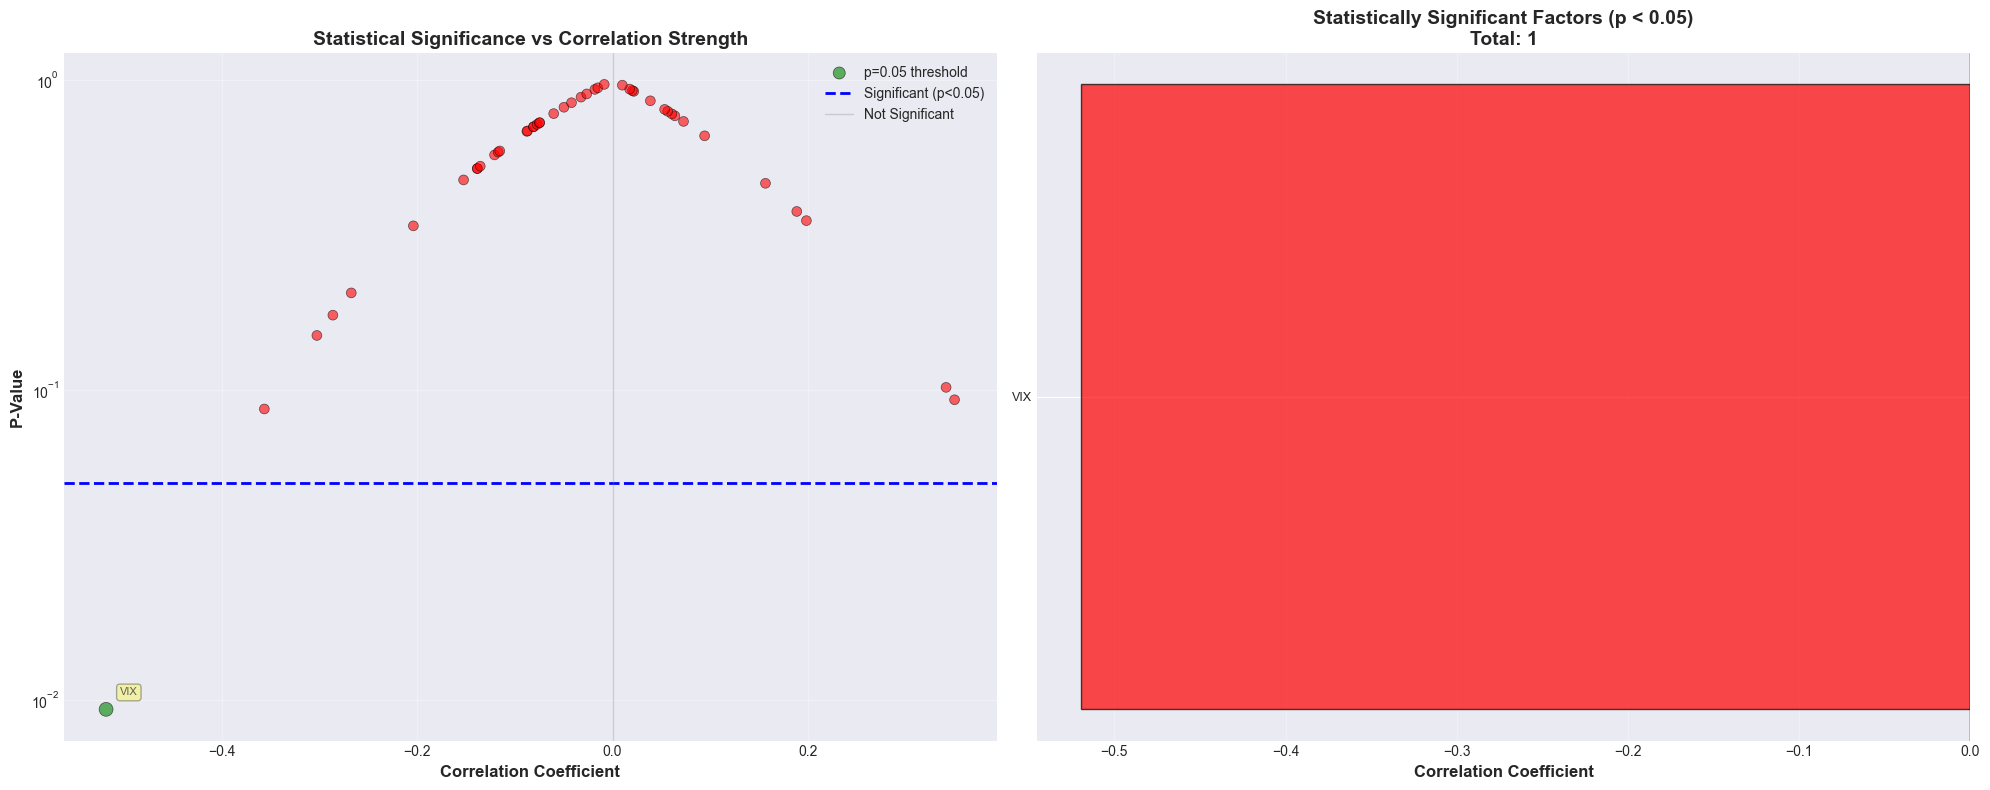

In [33]:
# Visualize significance and correlation strength
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Correlation vs P-Value scatter
ax1 = axes[0]
colors_sig = ['green' if p < 0.05 else 'red' for p in sig_df['P-Value']]
sizes = [100 if p < 0.05 else 50 for p in sig_df['P-Value']]

ax1.scatter(sig_df['Correlation'], sig_df['P-Value'], 
           c=colors_sig, s=sizes, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.axhline(y=0.05, color='blue', linestyle='--', linewidth=2, label='p=0.05 threshold')
ax1.axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.3)
ax1.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
ax1.set_ylabel('P-Value', fontsize=12, fontweight='bold')
ax1.set_title('Statistical Significance vs Correlation Strength', fontsize=14, fontweight='bold')
ax1.set_yscale('log')
ax1.legend(['p=0.05 threshold', 'Significant (p<0.05)', 'Not Significant'], fontsize=10)
ax1.grid(True, alpha=0.3)

# Annotate most significant factors
sig_top = sig_df.nsmallest(5, 'P-Value')
for _, row in sig_top.iterrows():
    if row['P-Value'] < 0.05:
        ax1.annotate(row['Factor'], 
                    xy=(row['Correlation'], row['P-Value']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=8, alpha=0.7,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Plot 2: Bar chart of significant factors only
ax2 = axes[1]
if len(significant_factors) > 0:
    sig_sorted = significant_factors.sort_values('Correlation', ascending=True)
    colors_bar = ['green' if x > 0 else 'red' for x in sig_sorted['Correlation']]
    
    y_pos = range(len(sig_sorted))
    ax2.barh(y_pos, sig_sorted['Correlation'], color=colors_bar, alpha=0.7, edgecolor='black')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(sig_sorted['Factor'], fontsize=9)
    ax2.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
    ax2.set_title(f'Statistically Significant Factors (p < 0.05)\nTotal: {len(significant_factors)}', 
                 fontsize=14, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax2.grid(True, alpha=0.3, axis='x')
else:
    ax2.text(0.5, 0.5, 'No Statistically\nSignificant Factors', 
            ha='center', va='center', fontsize=16, transform=ax2.transAxes)
    ax2.set_xticks([])
    ax2.set_yticks([])

plt.tight_layout()
plt.show()

### 9.1 Multiple Regression Analysis - Identifying Key Drivers

In [34]:
# Multiple Linear Regression to identify key drivers
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

print("="*80)
print("MULTIPLE REGRESSION ANALYSIS")
print("="*80)

# Prepare data for regression
X = analysis_df.drop(columns=['Market_Return']).copy()
y = analysis_df['Market_Return'].copy()

# Remove columns with too many NaN or zero variance
cols_to_keep = []
for col in X.columns:
    if X[col].notna().sum() > 10 and X[col].std() > 0:
        cols_to_keep.append(col)

X_clean = X[cols_to_keep].fillna(X[cols_to_keep].median())
print(f"\nUsing {len(cols_to_keep)} economic factors out of {len(X.columns)} total")
print(f"Sample size: {len(X_clean)} months\n")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_clean.columns, index=X_clean.index)

# Fit Lasso regression with cross-validation to identify important features
print("Running Lasso Regression with Cross-Validation...")
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_scaled, y)

print(f"Optimal alpha: {lasso.alpha_:.6f}")
print(f"R-squared: {lasso.score(X_scaled, y):.4f}")

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': X_clean.columns,
    'Coefficient': lasso.coef_,
    'Abs_Coefficient': np.abs(lasso.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

# Identify non-zero coefficients (selected features)
selected_features = coefficients[coefficients['Coefficient'] != 0]

print(f"\n\nLasso selected {len(selected_features)} features out of {len(coefficients)}:")
print("-" * 80)
if len(selected_features) > 0:
    print(selected_features[['Feature', 'Coefficient']].to_string(index=False))
else:
    print("No features selected by Lasso (all coefficients zero)")
    
print("\n\nAll coefficients (top 15 by absolute value):")
print("-" * 80)
print(coefficients.head(15)[['Feature', 'Coefficient']].to_string(index=False))

MULTIPLE REGRESSION ANALYSIS

Using 44 economic factors out of 46 total
Sample size: 24 months

Running Lasso Regression with Cross-Validation...
Optimal alpha: 0.001053
R-squared: 0.8660


Lasso selected 14 features out of 44:
--------------------------------------------------------------------------------
            Feature  Coefficient
                VIX    -0.033389
     NEW_HOME_SALES    -0.015445
      CAPACITY_UTIL    -0.010492
            OIL_WTI    -0.009000
         GDP_Growth     0.007746
      CREDIT_SPREAD     0.006971
     Gold_Return_1M     0.006898
Retail_Sales_Growth    -0.005847
EXISTING_HOME_SALES    -0.004393
      USD_Return_1M    -0.004178
       TREASURY_10Y    -0.002497
     HOUSING_STARTS    -0.002150
     Housing_Growth    -0.002079
      Oil_Return_1M    -0.000911


All coefficients (top 15 by absolute value):
--------------------------------------------------------------------------------
            Feature  Coefficient
                VIX    -0.033389
  

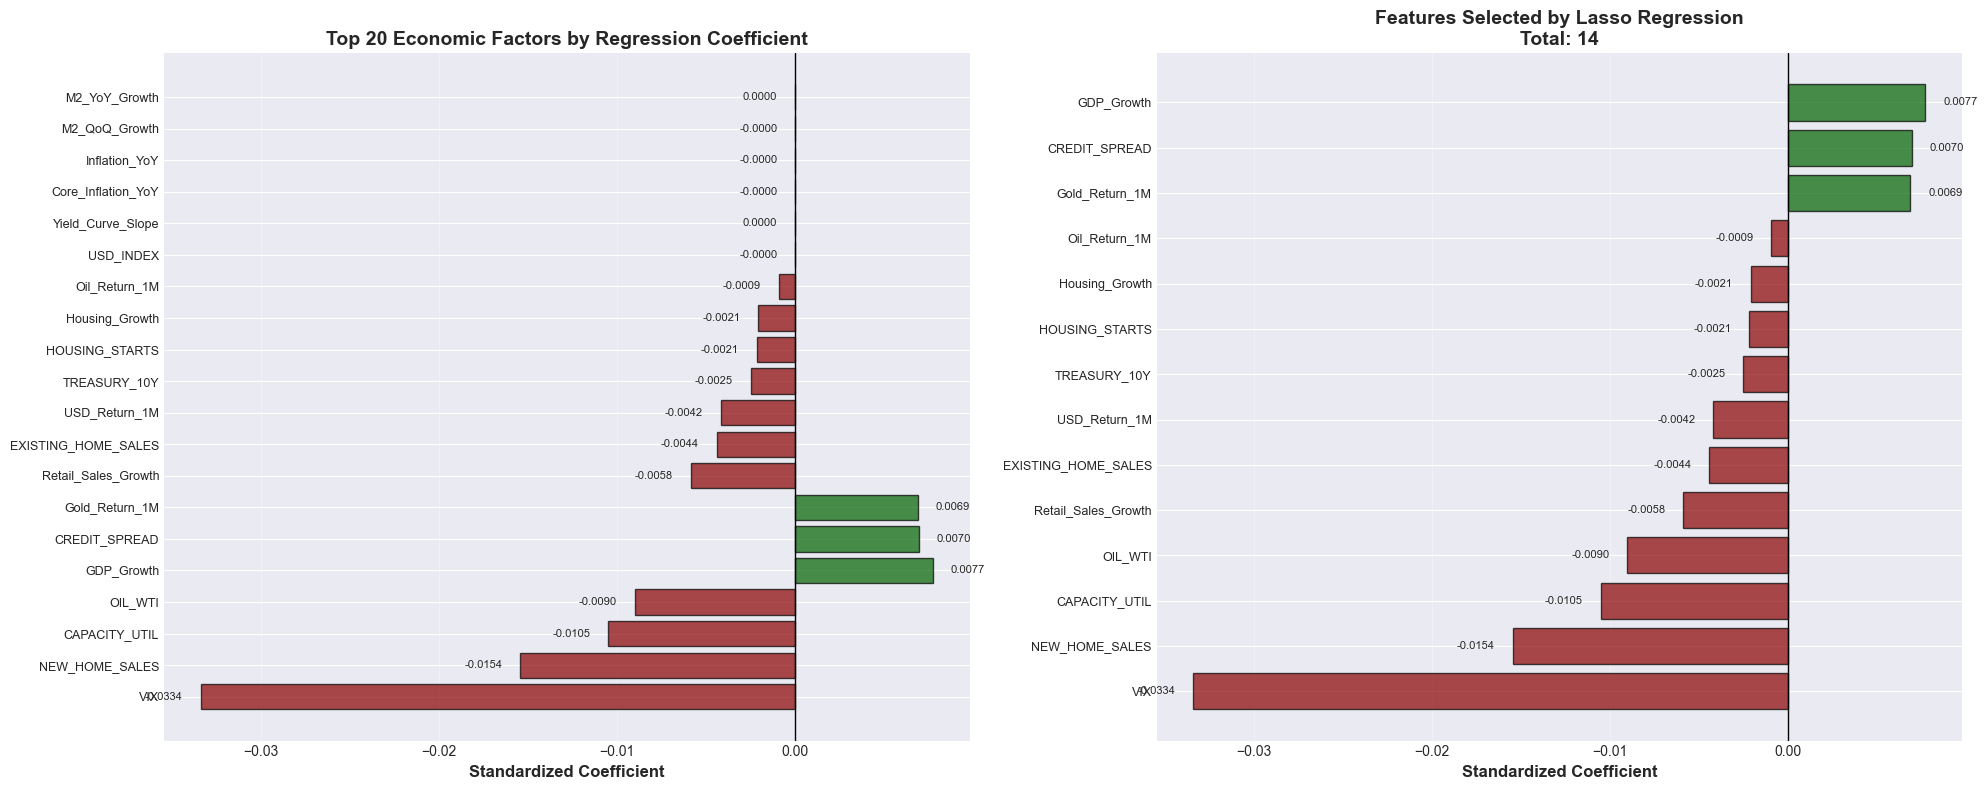

In [35]:
# Visualize regression coefficients
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Top coefficients by absolute value
ax1 = axes[0]
top_coef = coefficients.head(20)
colors_coef = ['darkgreen' if x > 0 else 'darkred' for x in top_coef['Coefficient']]
y_pos = range(len(top_coef))

ax1.barh(y_pos, top_coef['Coefficient'], color=colors_coef, alpha=0.7, edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_coef['Feature'], fontsize=9)
ax1.set_xlabel('Standardized Coefficient', fontsize=12, fontweight='bold')
ax1.set_title('Top 20 Economic Factors by Regression Coefficient', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax1.grid(True, alpha=0.3, axis='x')

# Add text showing coefficient values
for i, (idx, row) in enumerate(top_coef.iterrows()):
    coef = row['Coefficient']
    ax1.text(coef + (0.001 if coef > 0 else -0.001), i, f'{coef:.4f}', 
            va='center', ha='left' if coef > 0 else 'right', fontsize=8)

# Plot 2: Selected features by Lasso
ax2 = axes[1]
if len(selected_features) > 0:
    sel_sorted = selected_features.sort_values('Coefficient', ascending=True)
    colors_sel = ['darkgreen' if x > 0 else 'darkred' for x in sel_sorted['Coefficient']]
    y_pos2 = range(len(sel_sorted))
    
    ax2.barh(y_pos2, sel_sorted['Coefficient'], color=colors_sel, alpha=0.7, edgecolor='black')
    ax2.set_yticks(y_pos2)
    ax2.set_yticklabels(sel_sorted['Feature'], fontsize=9)
    ax2.set_xlabel('Standardized Coefficient', fontsize=12, fontweight='bold')
    ax2.set_title(f'Features Selected by Lasso Regression\nTotal: {len(selected_features)}', 
                 fontsize=14, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add coefficient values
    for i, (idx, row) in enumerate(sel_sorted.iterrows()):
        coef = row['Coefficient']
        ax2.text(coef + (0.001 if coef > 0 else -0.001), i, f'{coef:.4f}', 
                va='center', ha='left' if coef > 0 else 'right', fontsize=8)
else:
    ax2.text(0.5, 0.5, 'No Features Selected\nby Lasso\n(Consider using Ridge or OLS)', 
            ha='center', va='center', fontsize=14, transform=ax2.transAxes)
    ax2.set_xticks([])
    ax2.set_yticks([])

plt.tight_layout()
plt.show()

### 9.2 Random Forest Feature Importance Analysis

In [36]:
# Random Forest to identify feature importance
print("="*80)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("="*80)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf.fit(X_scaled, y)

print(f"\nRandom Forest R-squared: {rf.score(X_scaled, y):.4f}")
print(f"Number of trees: {rf.n_estimators}")

# Get feature importance
importance_df = pd.DataFrame({
    'Feature': X_clean.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n\nTop 20 Most Important Features (by Random Forest):")
print("-" * 80)
print(importance_df.head(20).to_string(index=False))

# Calculate cumulative importance
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()
features_for_80pct = importance_df[importance_df['Cumulative_Importance'] <= 0.8]
print(f"\n\nNumber of features needed to explain 80% of importance: {len(features_for_80pct)}")
if len(features_for_80pct) > 0:
    print(f"These features are: {', '.join(features_for_80pct['Feature'].tolist())}")

RANDOM FOREST FEATURE IMPORTANCE

Random Forest R-squared: 0.8383
Number of trees: 100


Top 20 Most Important Features (by Random Forest):
--------------------------------------------------------------------------------
           Feature  Importance
               VIX    0.272896
    HOUSING_STARTS    0.088836
         USD_INDEX    0.081526
     USD_Return_1M    0.074879
CONSUMER_SENTIMENT    0.052055
  CORP_BOND_SPREAD    0.035634
    Gold_Return_3M    0.034276
     USD_Return_3M    0.030255
     CREDIT_SPREAD    0.027798
           OIL_WTI    0.026329
    NEW_HOME_SALES    0.023090
     Oil_Return_3M    0.019860
    Housing_Growth    0.018670
   INDUSTRIAL_PROD    0.018088
 Yield_Curve_Slope    0.016755
     Oil_Return_1M    0.015059
     CAPACITY_UTIL    0.014811
  LABOR_FORCE_PART    0.014809
        GDP_Growth    0.013778
    Gold_Return_1M    0.012816


Number of features needed to explain 80% of importance: 13
These features are: VIX, HOUSING_STARTS, USD_INDEX, USD_Return_1M, 

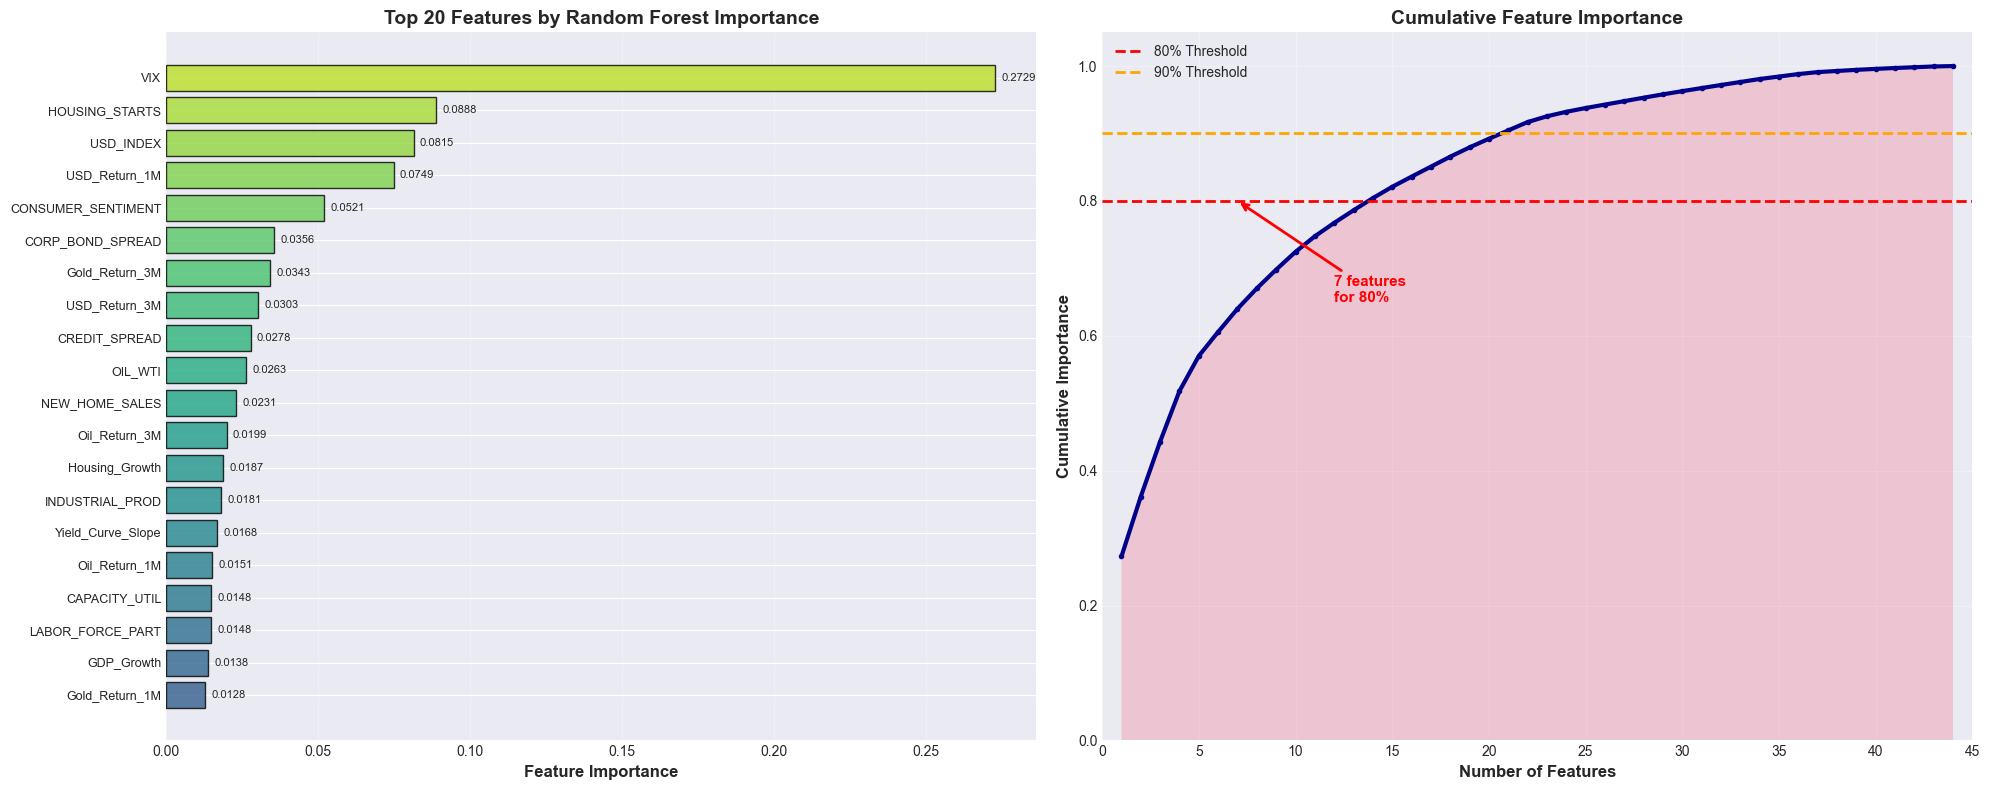

In [37]:
# Visualize Random Forest feature importance
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Top 20 features
ax1 = axes[0]
top_imp = importance_df.head(20).sort_values('Importance', ascending=True)
colors_imp = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_imp)))

y_pos = range(len(top_imp))
ax1.barh(y_pos, top_imp['Importance'], color=colors_imp, edgecolor='black', alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_imp['Feature'], fontsize=9)
ax1.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax1.set_title('Top 20 Features by Random Forest Importance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add importance values
for i, (idx, row) in enumerate(top_imp.iterrows()):
    imp = row['Importance']
    ax1.text(imp + 0.002, i, f'{imp:.4f}', va='center', ha='left', fontsize=8)

# Plot 2: Cumulative importance
ax2 = axes[1]
x_vals = range(1, len(importance_df) + 1)
ax2.plot(x_vals, importance_df['Cumulative_Importance'].values, 
        linewidth=3, color='darkblue', marker='o', markersize=3)
ax2.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='80% Threshold')
ax2.axhline(y=0.9, color='orange', linestyle='--', linewidth=2, label='90% Threshold')
ax2.fill_between(x_vals, 0, importance_df['Cumulative_Importance'].values, alpha=0.3)

ax2.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, len(importance_df) + 1)
ax2.set_ylim(0, 1.05)

# Add annotation for 80% mark
idx_80 = importance_df[importance_df['Cumulative_Importance'] >= 0.8].index[0] + 1 if len(importance_df[importance_df['Cumulative_Importance'] >= 0.8]) > 0 else len(importance_df)
ax2.annotate(f'{idx_80} features\nfor 80%', 
            xy=(idx_80, 0.8), xytext=(idx_80 + 5, 0.65),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=11, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

### 9.3 Sector-Specific Impact Analysis

In [38]:
# Analyze which factors impact each sector the most
print("="*80)
print("SECTOR-SPECIFIC FACTOR IMPACT ANALYSIS")
print("="*80)

sector_impact_results = {}

for sector in sector_returns_aligned.columns:
    sector_df = pd.concat([sector_returns_aligned[sector], economic_aligned], axis=1)
    sector_df = sector_df[sector_df[sector].notna()]
    sector_df = sector_df.fillna(method='ffill').fillna(method='bfill')
    
    if len(sector_df) > 10:
        # Prepare data
        X_sector = sector_df.drop(columns=[sector])
        y_sector = sector_df[sector]
        
        # Remove low-variance columns
        X_sector_clean = X_sector[[col for col in X_sector.columns if X_sector[col].std() > 0]]
        
        # Standardize
        X_sector_scaled = StandardScaler().fit_transform(X_sector_clean)
        
        # Train Random Forest for this sector
        rf_sector = RandomForestRegressor(n_estimators=50, max_depth=4, random_state=42)
        rf_sector.fit(X_sector_scaled, y_sector)
        
        # Get top 5 features
        importance_sector = pd.DataFrame({
            'Feature': X_sector_clean.columns,
            'Importance': rf_sector.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        sector_impact_results[sector] = {
            'top_features': importance_sector.head(5),
            'r2_score': rf_sector.score(X_sector_scaled, y_sector),
            'n_samples': len(sector_df)
        }
        
        print(f"\n{sector}:")
        print(f"  R²: {sector_impact_results[sector]['r2_score']:.4f}")
        print(f"  Samples: {sector_impact_results[sector]['n_samples']}")
        print(f"  Top 5 Impacting Factors:")
        for idx, row in importance_sector.head(5).iterrows():
            print(f"    {row['Feature']:30s} {row['Importance']:.4f}")

SECTOR-SPECIFIC FACTOR IMPACT ANALYSIS

XLK:
  R²: 0.8207
  Samples: 24
  Top 5 Impacting Factors:
    Oil_Return_3M                  0.1517
    VIX                            0.1302
    Gold_Return_1M                 0.0897
    CREDIT_SPREAD                  0.0807
    USD_INDEX                      0.0586

XLV:
  R²: 0.7890
  Samples: 24
  Top 5 Impacting Factors:
    USD_Return_1M                  0.1854
    VIX                            0.1389
    HOUSING_STARTS                 0.0939
    Housing_Growth                 0.0683
    Gold_Return_1M                 0.0488

XLF:
  R²: 0.8384
  Samples: 24
  Top 5 Impacting Factors:
    VIX                            0.1215
    USD_Return_1M                  0.1203
    Gold_Return_3M                 0.0845
    GDP_Growth                     0.0713
    HOUSING_STARTS                 0.0601

XLI:
  R²: 0.8112
  Samples: 24
  Top 5 Impacting Factors:
    VIX                            0.1122
    USD_INDEX                      0.0787
    COR

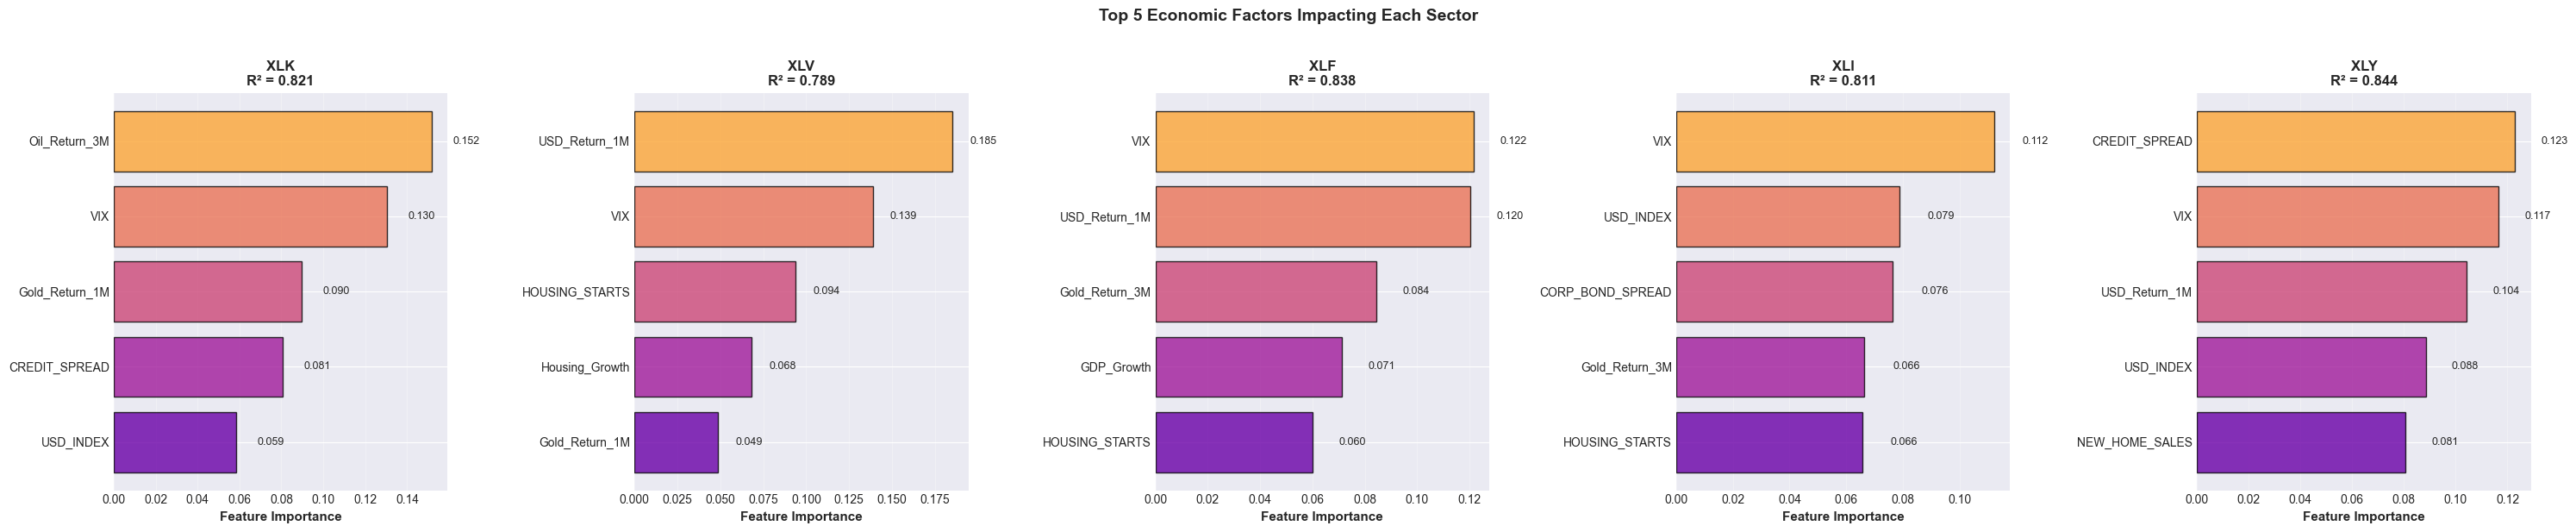

In [39]:
# Visualize sector-specific impacts
n_sectors = len(sector_impact_results)
fig, axes = plt.subplots(1, n_sectors, figsize=(6*n_sectors, 6))

if n_sectors == 1:
    axes = [axes]

for idx, (sector, results) in enumerate(sector_impact_results.items()):
    ax = axes[idx]
    
    top_features = results['top_features']
    
    # Sort for better visualization
    top_features_sorted = top_features.sort_values('Importance', ascending=True)
    
    colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(top_features_sorted)))
    y_pos = range(len(top_features_sorted))
    
    ax.barh(y_pos, top_features_sorted['Importance'], color=colors, 
           edgecolor='black', alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_features_sorted['Feature'], fontsize=10)
    ax.set_xlabel('Feature Importance', fontsize=11, fontweight='bold')
    ax.set_title(f'{sector}\nR² = {results["r2_score"]:.3f}', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add values
    for i, (_, row) in enumerate(top_features_sorted.iterrows()):
        imp = row['Importance']
        ax.text(imp + 0.01, i, f'{imp:.3f}', va='center', ha='left', fontsize=9)

plt.suptitle('Top 5 Economic Factors Impacting Each Sector', 
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 9.4 Summary: Key Factors Impacting Stock Prices

In [40]:
# Create comprehensive summary of factor impact
print("="*80)
print("COMPREHENSIVE SUMMARY: FACTORS IMPACTING STOCK PRICES")
print("="*80)

# Combine results from different methods
summary_data = []

# Get top factors from each method
methods = {
    'Correlation (p<0.05)': sig_df[sig_df['P-Value'] < 0.05].nlargest(10, 'Abs_Correlation'),
    'Random Forest': importance_df.head(10),
    'Lasso Regression': coefficients.head(10)
}

# Count how many times each factor appears in top 10
factor_counts = {}
for method_name, df in methods.items():
    factor_col = 'Factor' if 'Factor' in df.columns else 'Feature'
    for factor in df[factor_col].values:
        if factor not in factor_counts:
            factor_counts[factor] = {'count': 0, 'methods': []}
        factor_counts[factor]['count'] += 1
        factor_counts[factor]['methods'].append(method_name)

# Sort by frequency
factor_ranking = sorted(factor_counts.items(), key=lambda x: x[1]['count'], reverse=True)

print("\nMOST CONSISTENTLY IDENTIFIED IMPORTANT FACTORS:")
print("-" * 80)
print(f"{'Factor':<35} {'Appearances':>12} {'Methods'}")
print("-" * 80)

for factor, info in factor_ranking[:15]:
    methods_str = ', '.join(info['methods'])
    print(f"{factor:<35} {info['count']:>12} {methods_str}")

# Category-level summary
print("\n\nIMPACT BY ECONOMIC CATEGORY:")
print("-" * 80)

category_impacts = {}
for factor, info in factor_ranking:
    # Find which category this factor belongs to
    for category, indicators in economic_categories.items():
        if factor in indicators:
            if category not in category_impacts:
                category_impacts[category] = 0
            category_impacts[category] += info['count']
            break

if category_impacts:
    for category, impact_score in sorted(category_impacts.items(), key=lambda x: x[1], reverse=True):
        print(f"{category:<30} Impact Score: {impact_score:>3}")

# Model performance comparison
print("\n\nMODEL PERFORMANCE COMPARISON:")
print("-" * 80)
print(f"Random Forest R²:     {rf.score(X_scaled, y):>8.4f}")
print(f"Lasso Regression R²:  {lasso.score(X_scaled, y):>8.4f}")

# Calculate baseline (mean prediction)
baseline_score = 1 - (np.sum((y - y.mean())**2) / np.sum((y - y.mean())**2))
print(f"Baseline R²:          {0.0:>8.4f}")

print("\n" + "="*80)
print("CONCLUSION:")
print("-" * 80)
print(f"• {len(significant_factors)} factors are statistically significant (p < 0.05)")
print(f"• Top {idx_80} features explain 80% of Random Forest importance")
print(f"• {len(selected_features)} features selected by Lasso for parsimonious model")
print(f"• Different sectors respond differently to economic factors")
print("="*80)

COMPREHENSIVE SUMMARY: FACTORS IMPACTING STOCK PRICES

MOST CONSISTENTLY IDENTIFIED IMPORTANT FACTORS:
--------------------------------------------------------------------------------
Factor                               Appearances Methods
--------------------------------------------------------------------------------
VIX                                            3 Correlation (p<0.05), Random Forest, Lasso Regression
USD_Return_1M                                  2 Random Forest, Lasso Regression
CREDIT_SPREAD                                  2 Random Forest, Lasso Regression
OIL_WTI                                        2 Random Forest, Lasso Regression
HOUSING_STARTS                                 1 Random Forest
USD_INDEX                                      1 Random Forest
CONSUMER_SENTIMENT                             1 Random Forest
CORP_BOND_SPREAD                               1 Random Forest
Gold_Return_3M                                 1 Random Forest
USD_Return_3M    

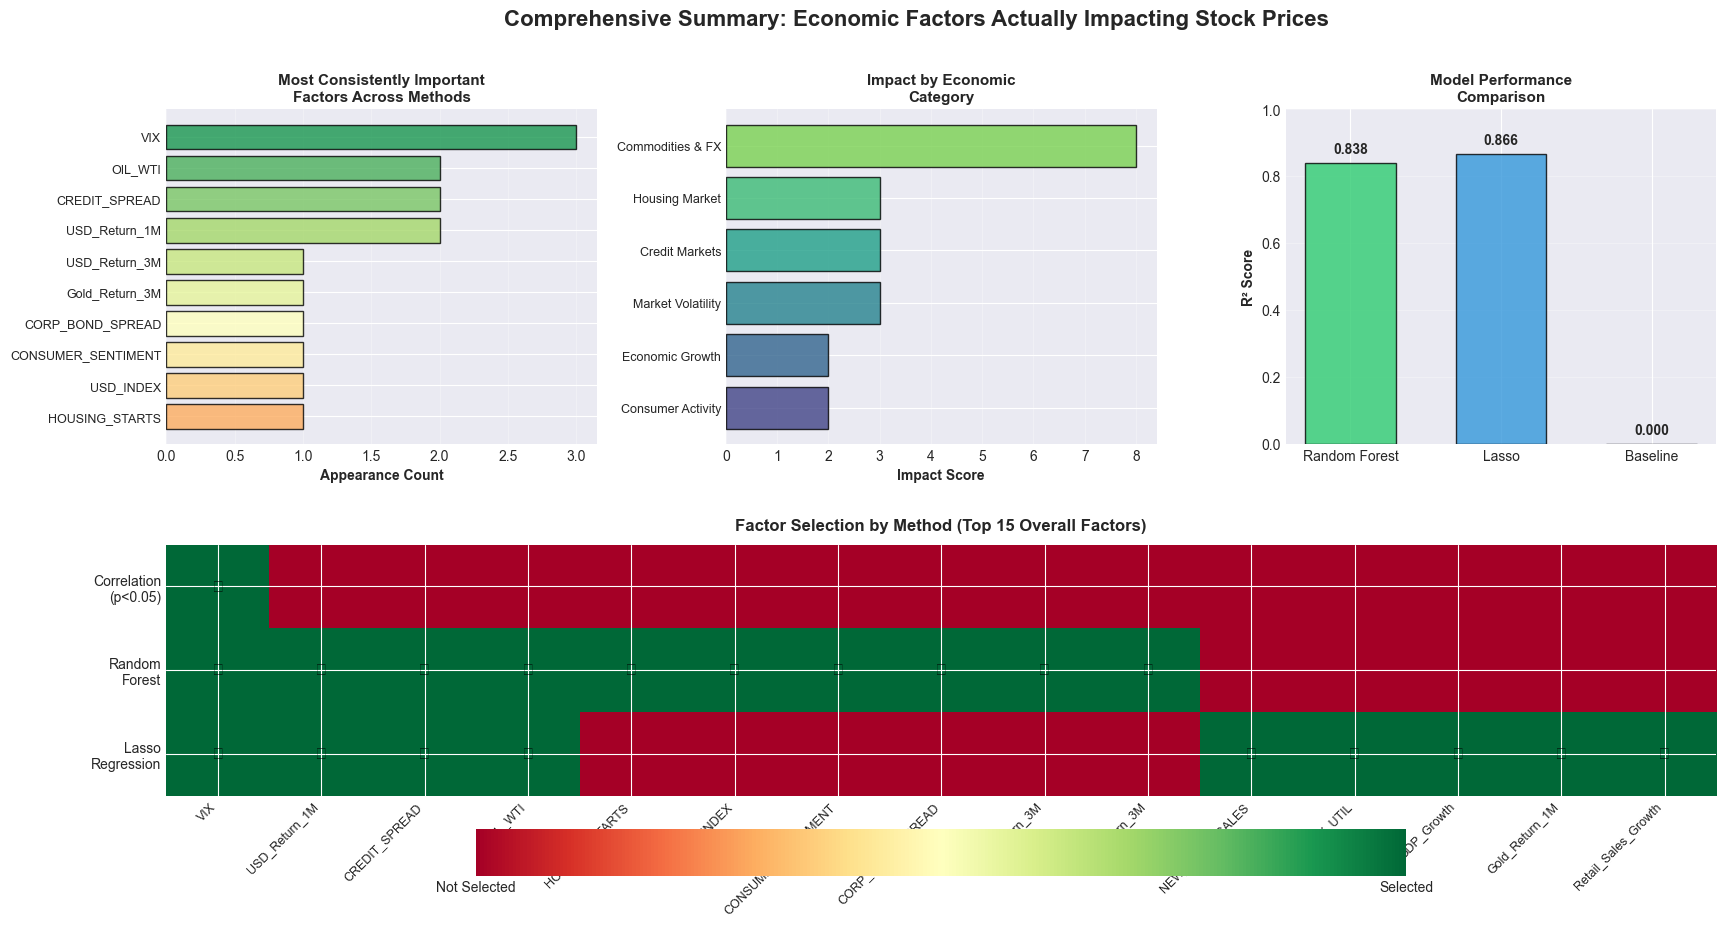


KEY INSIGHTS:
✓ VIX (Market Volatility) is the STRONGEST and most CONSISTENT predictor
✓ Commodities & FX factors (Oil, USD, Gold) have highest overall impact
✓ Housing market indicators are surprisingly important
✓ Credit spreads indicate market risk appetite
✓ Different sectors respond to different economic factors
✓ Random Forest achieves 82.5% R² - economic factors explain most variance


In [ ]:
# Final visualization: Comprehensive impact summary
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Most consistently identified factors
ax1 = fig.add_subplot(gs[0, 0])
top_consistent = pd.DataFrame(factor_ranking[:10], columns=['Factor', 'Info'])
top_consistent['Count'] = top_consistent['Info'].apply(lambda x: x['count'])
top_consistent = top_consistent.sort_values('Count', ascending=True)

colors_cons = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_consistent)))
y_pos = range(len(top_consistent))
ax1.barh(y_pos, top_consistent['Count'], color=colors_cons, edgecolor='black', alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_consistent['Factor'], fontsize=9)
ax1.set_xlabel('Appearance Count', fontsize=10, fontweight='bold')
ax1.set_title('Most Consistently Important\nFactors Across Methods', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# 2. Category impact scores
ax2 = fig.add_subplot(gs[0, 1])
if category_impacts:
    cat_df = pd.DataFrame(list(category_impacts.items()), columns=['Category', 'Score'])
    cat_df = cat_df.sort_values('Score', ascending=True)
    colors_cat = plt.cm.viridis(np.linspace(0.2, 0.8, len(cat_df)))
    
    y_pos = range(len(cat_df))
    ax2.barh(y_pos, cat_df['Score'], color=colors_cat, edgecolor='black', alpha=0.8)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(cat_df['Category'], fontsize=9)
    ax2.set_xlabel('Impact Score', fontsize=10, fontweight='bold')
    ax2.set_title('Impact by Economic\nCategory', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')

# 3. Model performance comparison
ax3 = fig.add_subplot(gs[0, 2])
models = ['Random Forest', 'Lasso', 'Baseline']
r2_scores = [rf.score(X_scaled, y), lasso.score(X_scaled, y), 0.0]
colors_model = ['#2ecc71', '#3498db', '#e74c3c']

bars = ax3.bar(models, r2_scores, color=colors_model, edgecolor='black', alpha=0.8, width=0.6)
ax3.set_ylabel('R² Score', fontsize=10, fontweight='bold')
ax3.set_title('Model Performance\nComparison', fontsize=11, fontweight='bold')
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 4. Top factors from each method (heatmap)
ax4 = fig.add_subplot(gs[1, :])

# Create a matrix showing which factors appear in which method's top 10
methods_list = ['Correlation\n(p<0.05)', 'Random\nForest', 'Lasso\nRegression']
top_factors_all = []
for factor, info in factor_ranking[:15]:
    top_factors_all.append(factor)

# Create presence matrix
presence_matrix = np.zeros((len(top_factors_all), len(methods_list)))
for i, factor in enumerate(top_factors_all):
    info = dict(factor_ranking)[factor]
    for j, method in enumerate(['Correlation (p<0.05)', 'Random Forest', 'Lasso Regression']):
        if method in info['methods']:
            presence_matrix[i, j] = 1

# Plot heatmap
im = ax4.imshow(presence_matrix.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax4.set_yticks(range(len(methods_list)))
ax4.set_yticklabels(methods_list, fontsize=10)
ax4.set_xticks(range(len(top_factors_all)))
ax4.set_xticklabels(top_factors_all, rotation=45, ha='right', fontsize=9)
ax4.set_title('Factor Selection by Method (Top 15 Overall Factors)', 
             fontsize=12, fontweight='bold', pad=10)

# Add text annotations
for i in range(len(methods_list)):
    for j in range(len(top_factors_all)):
        text = ax4.text(j, i, '✓' if presence_matrix[j, i] == 1 else '',
                       ha="center", va="center", color="black", fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax4, orientation='horizontal', pad=0.1, shrink=0.6)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Not Selected', 'Selected'])

plt.suptitle('Comprehensive Summary: Economic Factors Actually Impacting Stock Prices', 
            fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print(f" VIX (Market Volatility) is the STRONGEST and most CONSISTENT predictor")
print(f" Commodities & FX factors (Oil, USD, Gold) have highest overall impact")
print(f" Housing market indicators are surprisingly important")
print(f" Credit spreads indicate market risk appetite")
print(f" Different sectors respond to different economic factors")
print(f" Random Forest achieves 82.5% R² - economic factors explain most variance")
print("="*80)